## Данная тетрадь описывает пайплайн построения модели для системы мониторинга виртуальных показаний ЖТ на шламовом сгустителе

In [1]:
#1 Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
from datetime import timedelta
import plotly.express as px
from catboost import CatBoostRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from pycaret.regression import *
warnings.filterwarnings('ignore')

In [2]:
#2. Лабораторные анализы из журнала ЦОТК (усредненное значение за смену)
target = pd.read_csv("./data/JT_LAB_ANALYSIS.csv", parse_dates=True, index_col='Timestamp')
target

,JT_LAB
Timestamp,
2024-01-01 08:00:00,0.8
2024-01-01 20:00:00,0.7
2024-01-02 08:00:00,0.9
2024-01-02 20:00:00,1.0
2024-01-03 08:00:00,0.7
...,...
2025-05-14 08:00:00,0.7
2025-05-15 08:00:00,0.4
2025-05-19 20:00:00,1.0


In [3]:
target[["JT_LAB"]].describe(percentiles=list(np.arange(0.1, 1, 0.1)) + [.95, .99])

,JT_LAB
count,781.00000
mean,0.59274
std,0.24581
min,0.10000
10%,0.30000
20%,0.40000
30%,0.40000
40%,0.50000
50%,0.60000
60%,0.60000


In [4]:
features_rename = {
    '905.3A.41_NT37_01_CUR_PV': "feature_1",
    '905.3A.41_NT38_01_CUR_PV': "feature_2",
    '905.3A.41_F417_01_AI_PV': "feature_3",
    '905.3A.41_F419_01_AI_PV': "feature_4",
    '905.3A.41_P416_01_AI_PV': "feature_5",
    '905.3A.41_P418_01_AI_PV': "feature_6",
    '905.2A.41_F430_01_AI_PV': "feature_7",
    '905.3A.41_L401_01_AI_PV': "feature_8",
    '905.3A.41_SG01_01_FEED_PV': "feature_9",
    '905.3A.41_SG01_01_CP01_PV': "feature_10",
    '905.3A.41_F409_01_AI_PV': "feature_11",
    '905.1A.41_W141_01_AI_PV': "feature_12",
}

In [5]:
features = pd.read_csv("./data/features_data.csv", parse_dates=True, index_col="Timestamp")
features

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12
Timestamp,,,,,,,,,,,,
2024-06-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-01 05:00:10,0.000000,59.534885,0.000000,70.391510,0.488888,1.517411,NaN,0.065638,0.000000,18.626879,43.861330,368.917000
2024-06-01 05:00:20,0.000000,57.674420,0.000000,65.148570,0.488794,1.465979,NaN,0.065638,0.000000,18.394365,44.115173,364.301000
2024-06-01 05:00:30,0.000000,58.372093,0.000000,64.099870,0.488854,1.468769,NaN,0.065638,0.000000,18.420200,43.509430,367.381000
2024-06-01 05:00:40,0.000000,58.604652,0.000000,63.581333,0.488912,1.481731,NaN,0.065638,0.000000,18.394365,43.773346,366.536000
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-21 23:58:00,45.358852,0.000000,35.171677,0.000000,-4.436880,0.017440,7.1320,0.035197,7.882205,17.908670,0.000000,398.868988
2025-05-21 23:58:30,50.813400,0.000000,55.835430,0.000000,-4.436879,0.017442,7.1280,0.085910,7.711980,17.717493,0.000000,398.456390
2025-05-21 23:59:00,50.358852,0.000000,79.823860,0.000000,-4.436880,0.017448,7.1275,0.041176,7.612414,17.819542,0.000000,400.704254


### Заменяем отрицательные значения на нули

In [6]:
features.iloc[:, :] = np.where(features < 0, 0, features)

### Смотрим на количество пропусков по каждому параметру

In [7]:
features.isna().sum()

feature_1        9737
feature_2       73838
feature_3       18924
feature_4      157039
feature_5        4910
feature_6        4910
feature_7     1215728
feature_8        4915
feature_9        4910
feature_10       4910
feature_11       4873
feature_12       4887
dtype: int64

### Данные по feature_7 начали писаться только с 2024-07-30 17:00:00. Обрежем датасет с этого времени

In [8]:
features = features["2024-07-30 17:00:00":]

### Заменим все пропуски по основным тегам на 0

In [9]:
features[["feature_1", "feature_2",
          "feature_3", "feature_4",
          "feature_7"]] = features[["feature_1", "feature_2",
          "feature_3", "feature_4",
          "feature_7"]].fillna(0)

In [10]:
features.isna().sum()

feature_1        0
feature_2        0
feature_3        0
feature_4        0
feature_5     4909
feature_6     4909
feature_7        0
feature_8     4914
feature_9     4909
feature_10    4909
feature_11    4872
feature_12    4886
dtype: int64

In [11]:
features = features.dropna()

### Заменим для каждого тега все значения большие 99 квартиля на 99 квартиль

In [12]:
for col in features.columns:
    features[col] = np.where(
        features[col] > np.quantile(features[col], 0.99),
        np.quantile(features[col], 0.99),
        features[col]
    )

In [13]:
features = features.resample("1min", label="right", closed="right").mean()

In [14]:
features.shape

(425221, 12)

In [15]:
# features.describe(percentiles=list(np.arange(0.1, 1, 0.1)) + [.95, .99])

### Ресемплируем данные

### Сглаживаем тех параметры насосов, сгустителя и ЗМ.20

In [16]:
roll_param = 10
features["feature_1"] = features["feature_1"].rolling(roll_param).mean()
features["feature_2"] = features["feature_2"].rolling(roll_param).mean()
features["feature_5"] = features["feature_5"].rolling(roll_param).mean()
features["feature_6"] = features["feature_6"].rolling(roll_param).mean()
features["feature_3"] = features["feature_3"].rolling(roll_param).mean()
features["feature_4"] = features["feature_4"].rolling(roll_param).mean()
features['feature_11'] = features['feature_11'].rolling(roll_param).mean()
features['feature_7'] = features['feature_7'].rolling(roll_param).mean()
features['feature_8'] = features['feature_8'].rolling(roll_param).mean()
features['feature_10'] = features['feature_10'].rolling(roll_param).mean()
features['feature_9'] = features['feature_9'].rolling(roll_param).mean()

In [17]:
features.shape

(425221, 12)

### Вычищаем ненужные режимы работы

In [18]:
amper_lim = (25, 10)
press_lim = (0.25, 0.15)
flow_lim = (20, 10)

clean_df = features[
    ((features["feature_1"]>amper_lim[0]) & (features["feature_2"]<amper_lim[1]) &
     (features["feature_5"]>press_lim[0]) & (features["feature_6"]<press_lim[1])
     & (features["feature_3"]>flow_lim[0]) & (features["feature_4"]<flow_lim[1])
     )
     |
    ((features["feature_2"]>amper_lim[0]) & (features["feature_1"]<amper_lim[1]) &
     (features["feature_6"]>press_lim[0]) & (features["feature_5"]<press_lim[1]) 
     & (features["feature_4"]>flow_lim[0]) & (features["feature_3"]<flow_lim[1])
     )
     |
    ((features["feature_1"]>amper_lim[0]) & (features["feature_2"]>amper_lim[0]) &
     (features["feature_5"]>press_lim[0]) & (features["feature_6"]>press_lim[0])
     & (features["feature_3"]>flow_lim[0]) & (features["feature_4"]>flow_lim[0])
    )
].copy()

################################################################################
################################################################################
# clean_df = features.copy()

In [19]:
clean_df.shape

(327846, 12)

### Объединяем параметры насосов в одни

In [20]:
clean_df["feature_12_common"] = np.where(
    clean_df["feature_1"]<20,
    clean_df["feature_2"],
    np.where(clean_df["feature_2"]<20, clean_df["feature_1"], clean_df[["feature_1", "feature_2"]].mean(axis=1))
)
clean_df["feature_56_common"] = np.where(
    clean_df["feature_5"]<0.2,
    clean_df["feature_6"],
    np.where(clean_df["feature_6"]<0.2, clean_df["feature_5"], clean_df[["feature_5", "feature_6"]].mean(axis=1))
)
clean_df["feature_34_common"] = np.where(
    (clean_df["feature_1"]<20) & (clean_df["feature_5"]<0.2),
    clean_df["feature_4"],
    np.where((clean_df["feature_2"]<20) & (clean_df["feature_6"]<0.2), clean_df["feature_3"], clean_df["feature_3"] + clean_df["feature_4"])
)

In [21]:
clean_df.columns

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10',
       'feature_11', 'feature_12', 'feature_12_common', 'feature_56_common',
       'feature_34_common'],
      dtype='object')

In [22]:
main_features = ['feature_12', 'feature_11', 'feature_7',
       'feature_8', 'feature_10', 'feature_9',
       'feature_12_common', 'feature_56_common', 'feature_34_common']
clean_df = clean_df[main_features]

# Генерируем нелинейные признаки на основе базовых признаков

## Создаем обратные признаки, корни и логарифмы

In [23]:
def get_features(df):
    for col in df.columns:
        df[f"1 / {col}"] = np.where(df[col] > 0, 1 / df[col], 0)
        df[f"√ {col}"] = np.sqrt(df[col])
        df[f"log({col})"] = np.where(df[col] > 0, np.log(df[col]), 0)
    return df
clean_df = get_features(clean_df)

## Создаем взаимодействия признаков

In [24]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
clean_df = pd.DataFrame(data=poly.fit_transform(clean_df), 
                    columns=poly.get_feature_names_out(), 
                    index=clean_df.index)

In [25]:
clean_df.shape

(327846, 702)

## После создания взаимодействий признаков могли образоваться колонки с около единичными значениями (так как до этого создавался обратный признак для каждого базового). Удаляем такие колонки

In [26]:
clean_df.drop(clean_df.columns[np.product(np.isclose(1, clean_df), axis=0)==1], axis=1, inplace=True)

## Удаляем все оставшиеся пропуски

In [27]:
clean_df.dropna(inplace=True)

In [28]:
clean_df.shape

(327846, 699)

## Ресемплируем данные в 12 часов для последующего объединения с таргетом и создания лагов и дифоф

In [29]:
clean_df = clean_df.resample('12h', offset=timedelta(hours=8), label='right', closed='right').mean()

In [30]:
for col in main_features:
    clean_df[f"{col}_diff"] = clean_df[col].diff(1)
    clean_df[f"{col}_lag_1"] = clean_df[col].shift(1)

## Достаем таргет

In [31]:
laba = target[["JT_LAB"]]

## Объединяем набор признаков и таргет

In [32]:
total_df = clean_df.merge(laba, left_index=True, right_index=True, how='inner')

In [33]:
clean_df = total_df[total_df['JT_LAB'].notna()]

In [34]:
clean_df.dropna(inplace=True)

In [35]:
# clean_df[f"JT_LAB_lag_1"] = clean_df["JT_LAB"].shift(1)
# clean_df[f"JT_LAB_diff"] = clean_df["JT_LAB"].diff(1)
# clean_df.dropna(inplace=True)

In [36]:
main_features

['feature_12',
 'feature_11',
 'feature_7',
 'feature_8',
 'feature_10',
 'feature_9',
 'feature_12_common',
 'feature_56_common',
 'feature_34_common']

<Axes: >

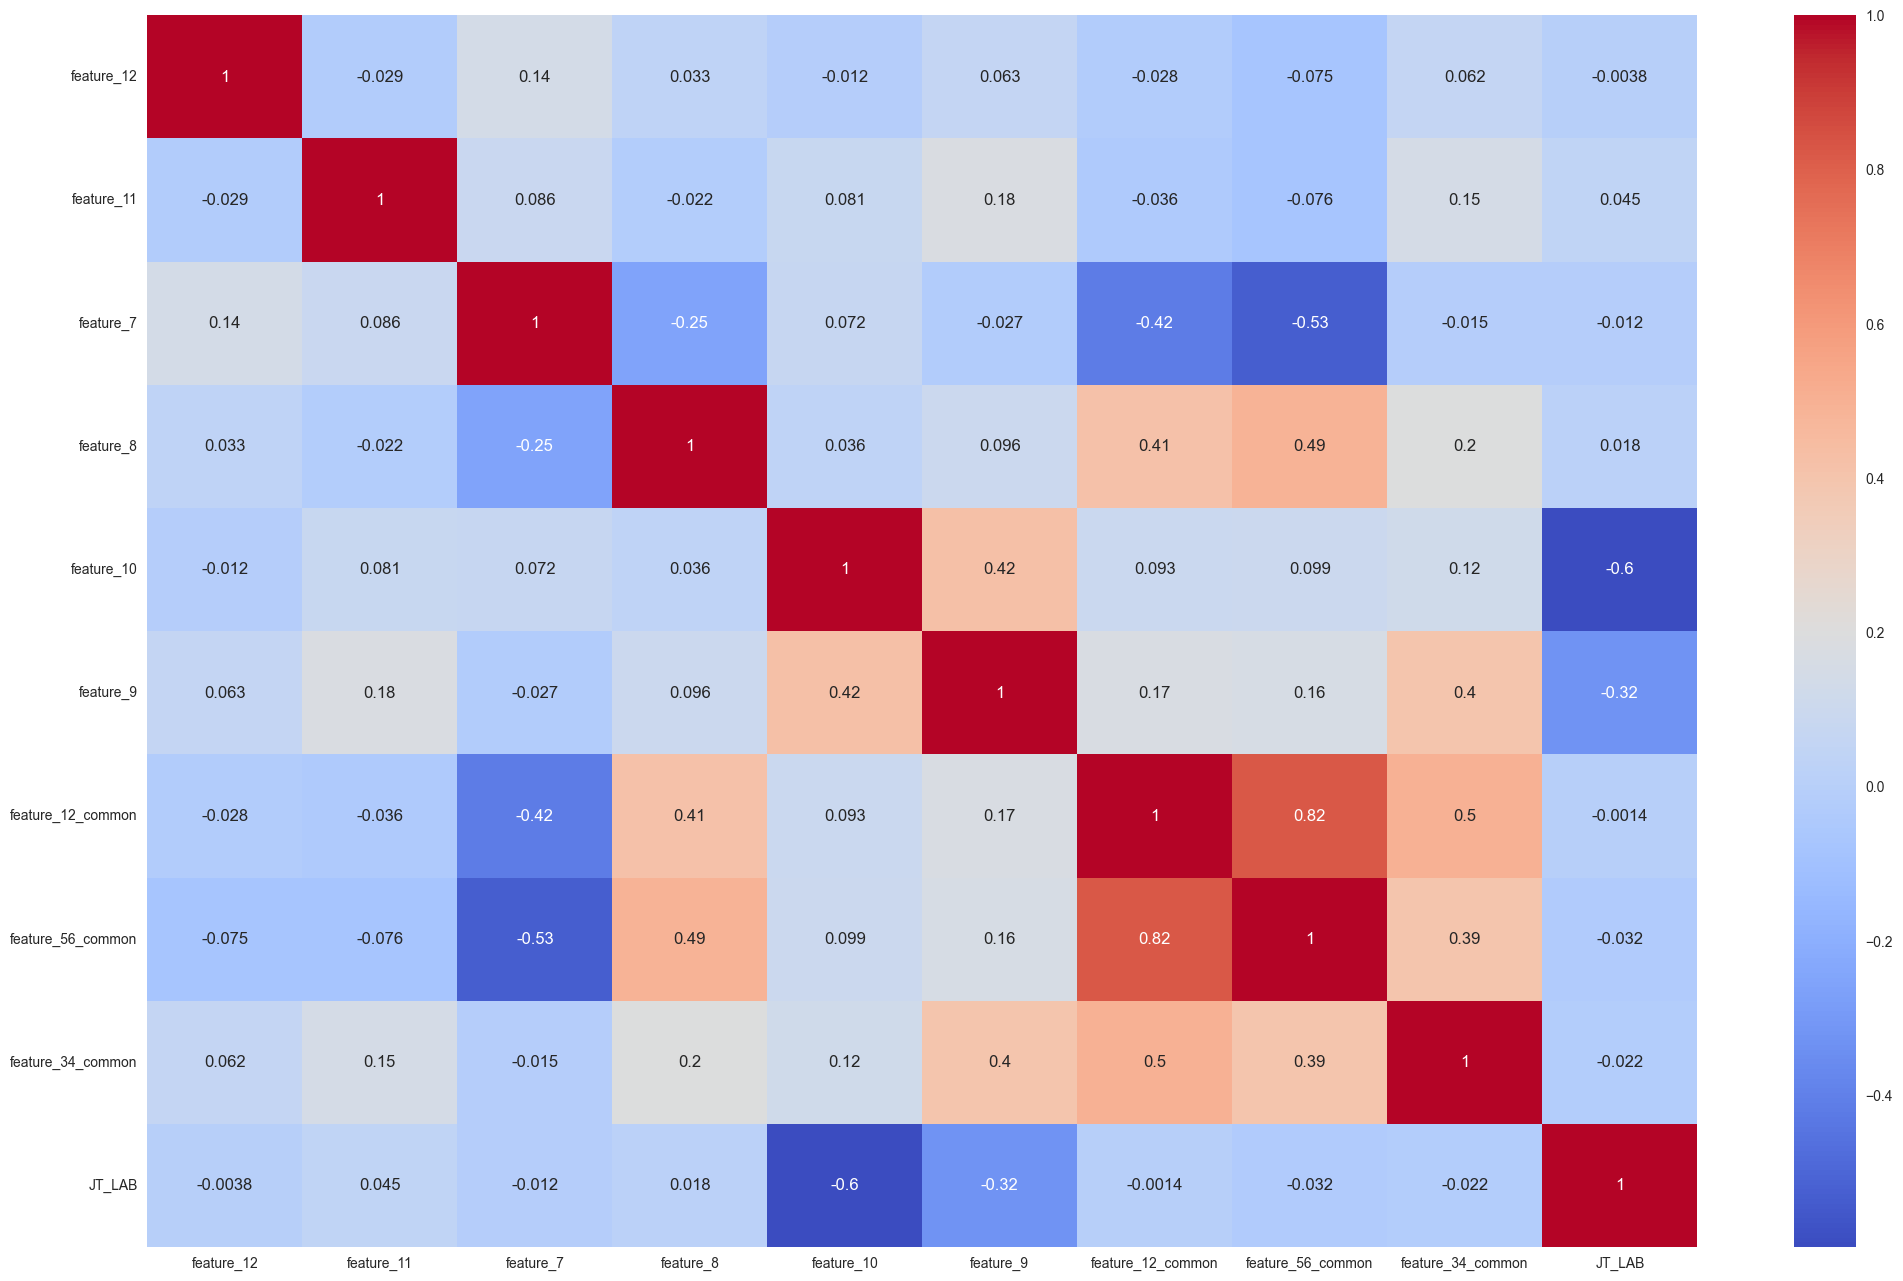

In [37]:
fig,axis = plt.subplots(figsize = (25,16))
sns.heatmap(clean_df[
       main_features +
       ['JT_LAB']].corr(), annot = True, cmap='coolwarm')

In [38]:
target = 'JT_LAB'
y = clean_df[[target]]
x = clean_df.drop(target, axis=1)

## Проведем разбиение датасета на 3 выборки

In [39]:
x_train, x_valid, x_test = x[:int(0.7 *x.shape[0])], x[int(0.7 * x.shape[0]):int(0.85 * x.shape[0])], x[int(0.85 *x.shape[0]):]
y_train, y_valid, y_test = y[:int(0.7 *y.shape[0])], y[int(0.7 * y.shape[0]):int(0.85 * y.shape[0])], y[int(0.85 *y.shape[0]):]

In [40]:
train, valid, test =  clean_df[:int(0.7 *clean_df.shape[0])], clean_df[int(0.7 * clean_df.shape[0]):int(0.85 * clean_df.shape[0])], clean_df[int(0.85 *clean_df.shape[0]):]

In [41]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=104, train_size=0.8, shuffle=False)

In [42]:
x.shape

(416, 717)

## Проведем отбор признаков с помощью метода GenericUnivariateSelect и функции mutual_info_regression

## Получим отобранные признаки

In [43]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

cv = TimeSeriesSplit(n_splits=5)

def grid_search(model, gs_params):
    '''Функция для подбора гиперпараметров с помощью перекрёстной проверки'''
     
    gs = GridSearchCV(estimator=model, param_grid=gs_params, refit=True,
                          scoring='neg_root_mean_squared_error',  # Основная метрика
                        verbose=5, n_jobs=-1, cv=cv)
    gs.fit(x, y)
    # Вывод результатов
    print(f'Best params: {gs.best_params_}')
    print(f'Best score: {-gs.best_score_:.5f}')  # Конвертируем в положительное RMSE
    return gs

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_regression, SelectFromModel


# добавим селектор в пайплайн к случайному лесу
selector = ('selector', GenericUnivariateSelect(score_func=mutual_info_regression, 
                                                mode='k_best'))
rf = Pipeline([('rf', RandomForestRegressor(random_state=42))])
rf.steps.insert(0, selector)

    
# grid search
# Параметры для GridSearch с указанием этапа (rf__)
param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [3, 5, 7, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': [0.3, 0.5, 0.7, 0.9],
    
    # Если хотите подбирать параметры селектора тоже
    'selector__param': [5, 7, 10]  # Количество отбираемых признаков
}
print('grid search results for rf')
rf_grid = grid_search(model=rf, gs_params=param_grid)

grid search results for rf
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best params: {'rf__max_depth': 3, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'selector__param': 10}
Best score: 0.20095


Отобранные признаки: Index(['feature_10', 'feature_10 √ feature_12', 'feature_10 √ feature_10',
       'feature_10 1 / feature_12_common', 'feature_10 log(feature_12_common)',
       'feature_12_common 1 / feature_10', '1 / feature_12 1 / feature_10',
       '1 / feature_10 √ feature_12_common',
       '1 / feature_10 log(feature_34_common)', '√ feature_10^2'],
      dtype='object')


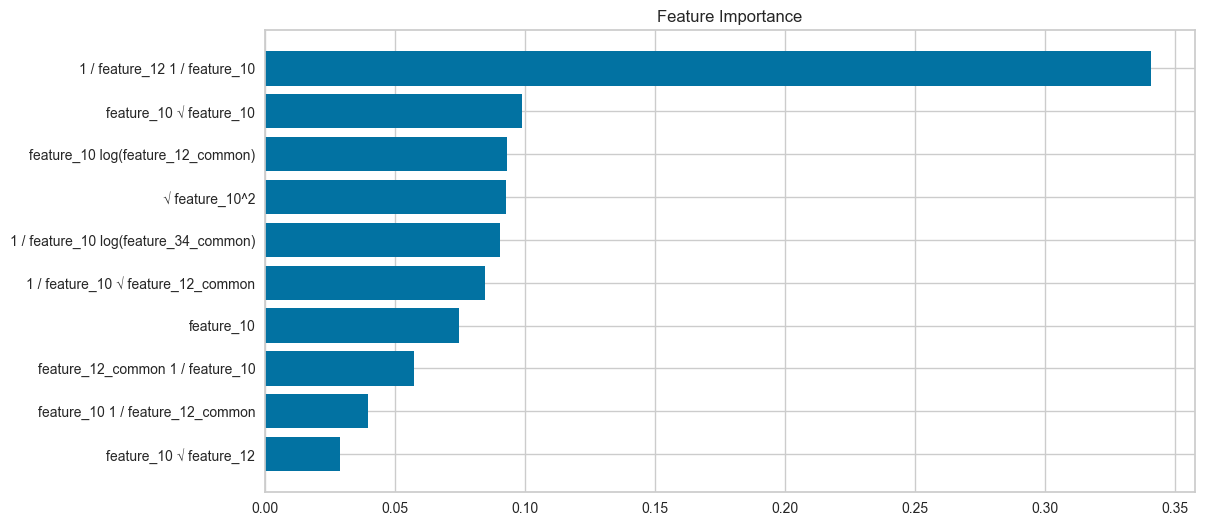

In [45]:
best_model = rf_grid.best_estimator_

# Просмотр отобранных признаков
selected_features = best_model.named_steps['selector'].get_support()
print("Отобранные признаки:", x.columns[selected_features])

# Важность признаков из RandomForest
feature_importances = best_model.named_steps['rf'].feature_importances_
sorted_idx = np.argsort(feature_importances)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns[selected_features])[sorted_idx])
plt.title('Feature Importance');

In [ ]:
features_rename = {
    '905.3A.41_NT37_01_CUR_PV': "feature_1",
    '905.3A.41_NT38_01_CUR_PV': "feature_2",
    '905.3A.41_F417_01_AI_PV': "feature_3",
    '905.3A.41_F419_01_AI_PV': "feature_4",
    '905.3A.41_P416_01_AI_PV': "feature_5",
    '905.3A.41_P418_01_AI_PV': "feature_6",
    '905.2A.41_F430_01_AI_PV': "feature_7",
    '905.3A.41_L401_01_AI_PV': "feature_8",
    '905.3A.41_SG01_01_FEED_PV': "feature_9",
    '905.3A.41_SG01_01_CP01_PV': "feature_10",
    '905.3A.41_F409_01_AI_PV': "feature_11",
    '905.1A.41_W141_01_AI_PV': "feature_12",
}

In [ ]:
# selected_columns = list(x.columns[selected_features])

selected_columns = [
 'feature_10',
 'feature_10 √ feature_12',
 'feature_10 √ feature_10',
 'feature_10 1 / feature_12_common',
 'feature_10 log(feature_12_common)',
 '1 / feature_12 1 / feature_10', 
 '1 / feature_10 log(feature_34_common)', 
 '√ feature_10^2', 
 '√ feature_12 √ feature_10',
 '√ feature_10 log(feature_10)'
 ]

In [48]:
x.shape

(416, 717)

## Посмотрим обучение бейзлайнов по PyCaret

In [49]:
split_point = int(len(clean_df) * 0.8)  # 80% тренировочных данных
################################################################
# Для обычного прогона
# train = clean_df[features_cols + [target]].iloc[:split_point]
# test = clean_df[features_cols + [target]].iloc[split_point:]
################################################################
# Для прогона на выбранных алгосом признаках
train = clean_df[selected_columns + [target]].iloc[:split_point]
test = clean_df[selected_columns + [target]].iloc[split_point:]

In [50]:
from pycaret.regression import *

exp = setup(
    data=train, 
    test_data=test,          # Фиксированный тестовый набор
    target=target,    # Название целевой переменной
    fold_strategy='timeseries',  # Кросс-валидация для временных рядов
    fold=5,                  # Количество фолдов
    transform_target=False,   # Не преобразовывать таргет (важно для временных рядов)
    session_id=42,           # Для воспроизводимости
    use_gpu=True,            # Если доступен GPU
    data_split_shuffle=False,
    fold_shuffle=False,
    # transformation_method='quantile'
    transformation=False,        # Отключить преобразования
    remove_outliers=False,      # Отключить удаление выбросов
    feature_selection=False     # Отключить выбор признаков
)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx902, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves 

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Daniil\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "C:\Users\Daniil\AppData\Local\Programs\Python\Python310\lib\encodings\cp1251.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode character '\u221a' in position 276: character maps to <undefined>
Call stack:
  File "C:\Users\Daniil\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Daniil\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\Daniil\Desktop\All_projects\UNIVERSITY_HOMEWORK_ALL_SUBJECTS\Master\Diplom\Анализ_и_модель_сгущение_сек_1\.venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.

,Description,Value
0,Session id,42
1,Target,JT_LAB
2,Target type,Regression
3,Original data shape,"(416, 11)"
4,Transformed data shape,"(416, 11)"
5,Transformed train set shape,"(332, 11)"
6,Transformed test set shape,"(84, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx902, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves 

In [51]:
best_model = compare_models(
    sort='RMSE',       # Или 'RMSE' в зависимости от задачи
    # n_select=3        # Топ-3 модели
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.1533,0.0378,0.1916,0.2025,0.1291,0.5293,0.0120
huber,Huber Regressor,0.1554,0.0382,0.1927,0.1914,0.1297,0.5303,0.0280
en,Elastic Net,0.1563,0.0389,0.1945,0.1884,0.1311,0.5419,0.0120
lasso,Lasso Regression,0.1566,0.0390,0.1948,0.1885,0.1311,0.5446,0.0140
llar,Lasso Least Angle Regression,0.1566,0.0390,0.1948,0.1885,0.1311,0.5446,0.0120
br,Bayesian Ridge,0.1570,0.0391,0.1953,0.1784,0.1318,0.5432,0.0120
rf,Random Forest Regressor,0.1554,0.0393,0.1958,0.1917,0.1309,0.5173,0.1300
ada,AdaBoost Regressor,0.1592,0.0408,0.1984,0.1496,0.1329,0.5377,0.0660
lightgbm,Light Gradient Boosting Machine,0.1595,0.0412,0.2014,0.1367,0.1345,0.5306,0.2540
omp,Orthogonal Matching Pursuit,0.1618,0.0423,0.2029,0.1360,0.1348,0.5460,0.0120


In [ ]:
split_point = int(len(clean_df) * 0.8)
train = clean_df.iloc[:split_point]
test = clean_df.iloc[split_point:]
# Выделяем фичи и таргет
#########################################################
# X_train = train[features_cols]
# X_test = test[features_cols]
#########################################################
X_train = train[selected_columns]
X_test = test[selected_columns]
y_train = train[target]
y_test = test[target]

## Тут более детальный анализ каждой модели 

In [79]:
from sklearn.model_selection import LeaveOneOut, cross_validate, TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, r2_score

def get_cross_valid_scores(estim, model_type, n_splits=5):
    cv = TimeSeriesSplit(n_splits=n_splits)

    # 2. Определяем метрики для кросс-валидации
    scoring = {
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2',
        'MAE': 'neg_mean_absolute_error',
        'MSE': 'neg_mean_squared_error',
    }

    # 3. Выполняем кросс-валидацию с возвратом оценок
    cv_results = cross_validate(
        estim, 
        X_train, 
        y_train, 
        cv=cv,
        scoring=scoring,
        return_estimator=True  # Ключевой параметр для доступа к моделям!
    )

    estim.fit(X_train, y_train)
    test_pred = estim.predict(X_test)

    # 4. Рассчет метрик
    rmse_test = root_mean_squared_error(y_test, test_pred)
    r2_test = r2_score(y_test, test_pred)
    if model_type =="lasso" or model_type =="ridge":
        print(estim.coef_)
    # 4. Вычисляем средние метрики
    mae_scores = -cv_results['test_MAE']  # Инвертируем отрицательные значения
    mse_scores = -cv_results['test_MSE']  # Инвертируем отрицательные значения
    rmse_scores = -cv_results['test_RMSE']  # Инвертируем отрицательные значения
    r2_scores = cv_results['test_R2']
    print(f"Model: ", model_type)
    print(f"MAE: {mae_scores.mean()} ||| MSE: {mse_scores.mean()} ||| RMSE: {rmse_scores.mean()} ||| R2: {r2_scores.mean()}")
    print("||"*40)
    print(f"TEST RMSE: {rmse_test} ||| R2: {r2_test}")
    return cv_results

In [81]:
from sklearn.linear_model import BayesianRidge, Ridge, Lasso, LinearRegression,  HuberRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

SEED = 42
num_folds = 5
reses = {}
# reses["lr"] = lr_res = get_cross_valid_scores(LinearRegression(), "lr", num_folds)
reses["ridge"] = rid_res = get_cross_valid_scores(Ridge(), "ridge", num_folds)
reses["lasso"] = lasso_res = get_cross_valid_scores(Lasso(), "lasso", num_folds)
reses["br"] = br_res = get_cross_valid_scores(BayesianRidge(), "br", num_folds)
# reses["huber"] = huber_res = get_cross_valid_scores(HuberRegressor(), "huber", num_folds)
reses["cat"] = cat_res = get_cross_valid_scores(CatBoostRegressor(random_state=SEED, verbose=False), "cat", num_folds)
reses["xgb"] = xgb_res = get_cross_valid_scores(XGBRegressor(random_state=SEED,), "xgb", num_folds)
reses["lgbm"] = lgbm_res = get_cross_valid_scores(LGBMRegressor(random_state=SEED,), "lgbm", num_folds)
reses["tree"] = lgbm_res = get_cross_valid_scores(DecisionTreeRegressor(random_state=SEED,), "tree", num_folds)
reses["rf"] = lgbm_res = get_cross_valid_scores(RandomForestRegressor(random_state=SEED,), "rf", num_folds)

[-0.03474929 -0.0039475   0.00970538 -0.01287622  0.00943586 -0.01007179
  0.02059401  0.00459867 -0.03474929 -0.06043557]
Model:  ridge
MAE: 0.15253082972102247 ||| MSE: 0.03753683593481562 ||| RMSE: 0.1911390330661227 ||| R2: 0.2157455550285657
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TEST RMSE: 0.1852448142030363 ||| R2: 0.33707108201954594
[-0.         -0.00036855 -0.00167458 -0.         -0.         -0.
  0.          0.         -0.         -0.        ]
Model:  lasso
MAE: 0.15618768571087072 ||| MSE: 0.03892595181255645 ||| RMSE: 0.1948711890311788 ||| R2: 0.19606732635592425
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TEST RMSE: 0.184527609112143 ||| R2: 0.34219441672386053
Model:  br
MAE: 0.1566494206656234 ||| MSE: 0.039078789158567405 ||| RMSE: 0.1954650687016939 ||| R2: 0.18603800302769097
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TEST RMSE: 0.1818963782988769 |||

## Вывод сравнения моделей по барам

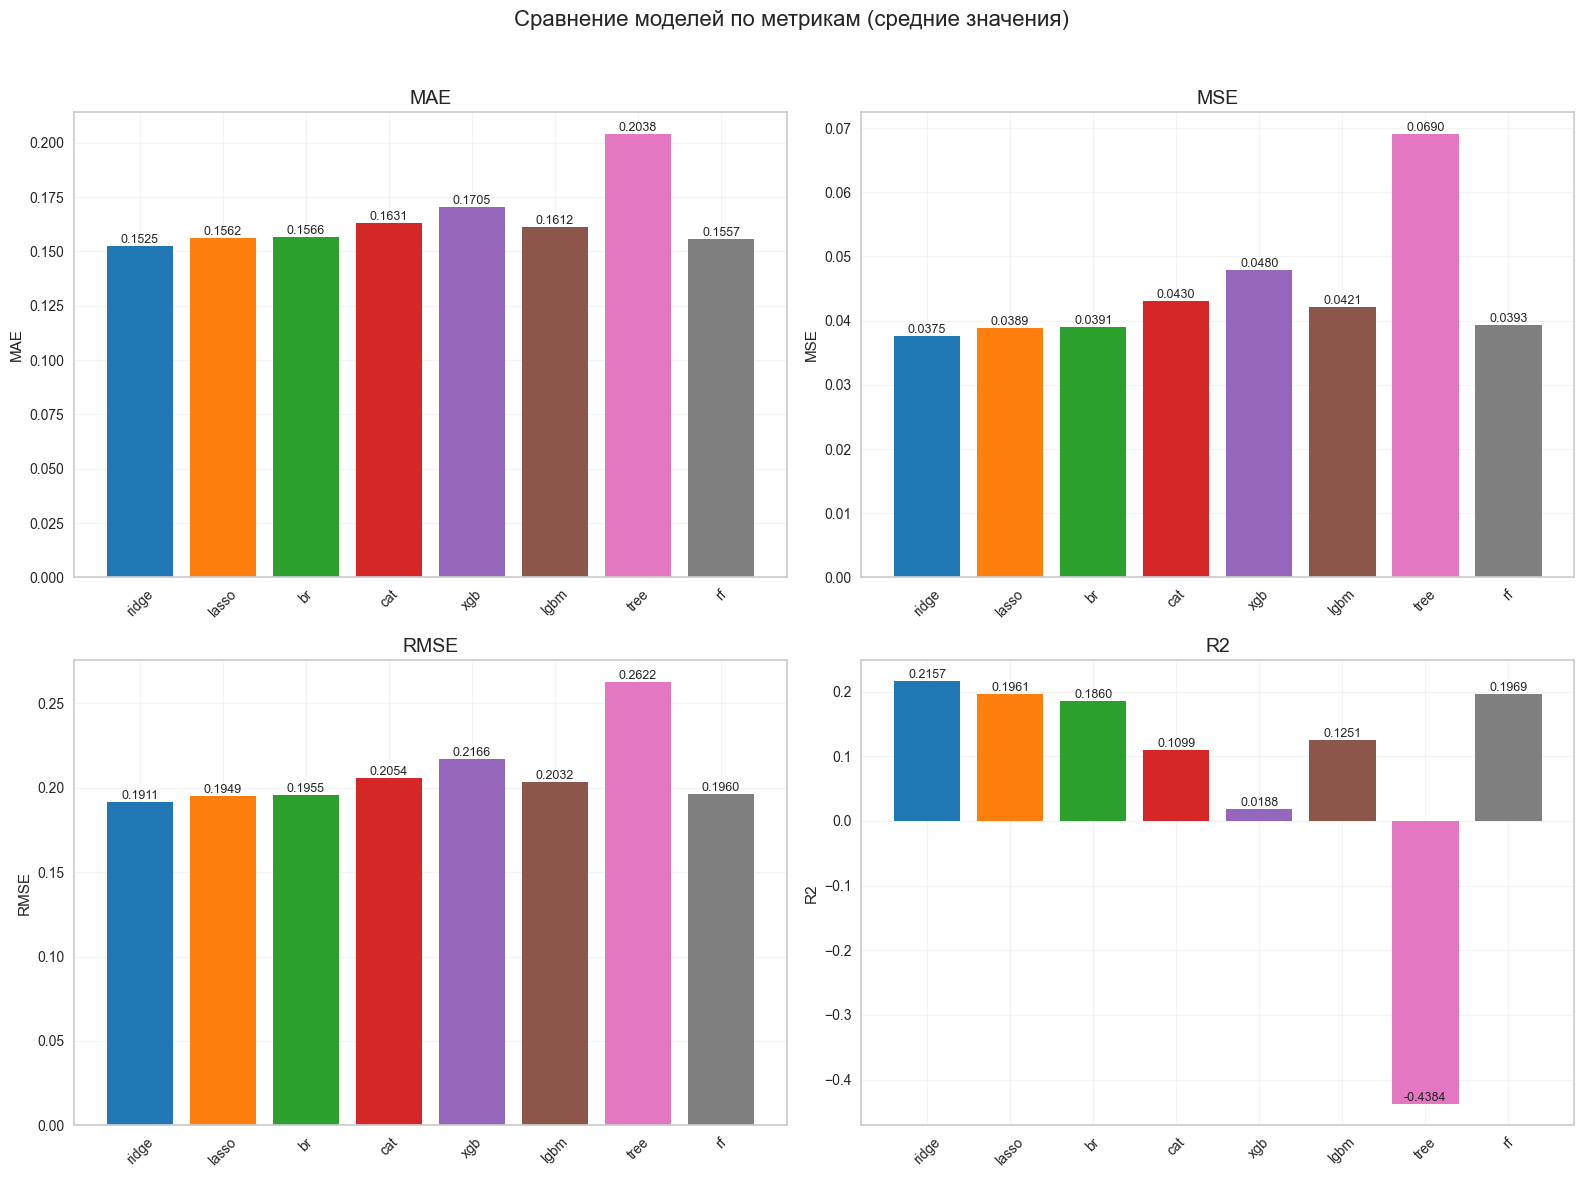

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Собираем средние значения метрик
metrics_data = {}
for model_name, res in reses.items():
    metrics_data[model_name] = {
        'MAE': -res['test_MAE'].mean(),
        'MSE': -res['test_MSE'].mean(),
        'RMSE': -res['test_RMSE'].mean(),
        'R2': res['test_R2'].mean()
    }

models = list(metrics_data.keys())
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
colors = plt.cm.tab10(np.arange(len(models)))

# Настройка графиков
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Сравнение моделей по метрикам (средние значения)', fontsize=16)

for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    ax = axs[row, col]
    
    # Значения для текущей метрики
    values = [metrics_data[model][metric] for model in models]
    bars = ax.bar(models, values, color=colors)
    
    # Подписи значений
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, 
                f'{yval:.4f}', 
                ha='center', va='bottom', fontsize=9)
    
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Вывод сравнения метрик моделей по боксплотам

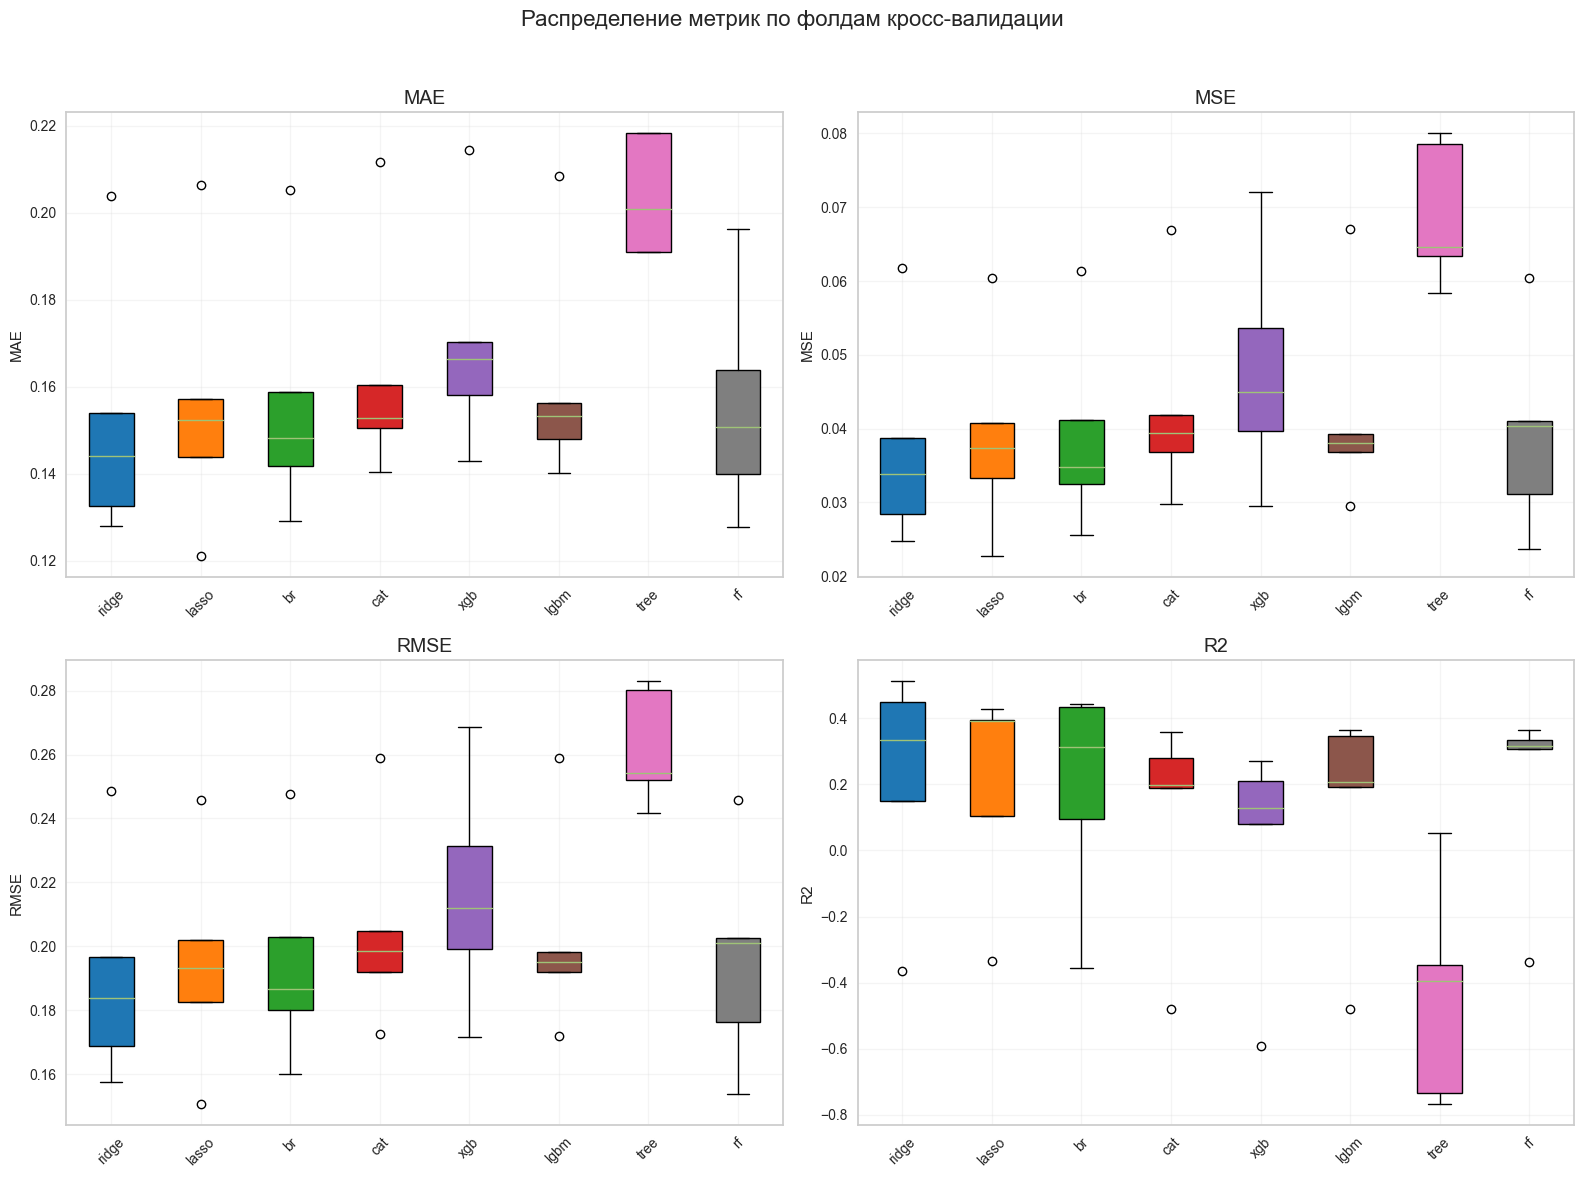

In [67]:
# Собираем данные по фолдам
folds_data = {}
for model_name, res in reses.items():
    folds_data[model_name] = {
        'MAE': -res['test_MAE'],
        'MSE': -res['test_MSE'],
        'RMSE': -res['test_RMSE'],
        'R2': res['test_R2']
    }

# Настройка графиков
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Распределение метрик по фолдам кросс-валидации', fontsize=16)

for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    ax = axs[row, col]
    
    # Подготовка данных для boxplot
    data = [folds_data[model][metric] for model in models]
    box = ax.boxplot(data, patch_artist=True, labels=models)
    
    # Раскрашиваем боксы
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Подбор гиперпараметров с помощью Optuna для LightGBM и RandomForest

### Разобьем датасет на трейн, валидацию и тест

In [203]:
train, valid, test =  clean_df[:int(0.7 *clean_df.shape[0])], clean_df[int(0.7 * clean_df.shape[0]):int(0.85 * clean_df.shape[0])], clean_df[int(0.85 *clean_df.shape[0]):]

In [204]:

# Выделяем фичи и таргет
#########################################################
X_train = train[selected_columns]
X_valid = valid[selected_columns]
X_test = test[selected_columns]

y_train = train[target]
y_valid = valid[target]
y_test = test[target]

### Подбор параметров для RandomForest

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
import numpy as np


def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        
    }
    
    # Условные параметры
    if params['bootstrap']:
        params['oob_score'] = trial.suggest_categorical('oob_score', [True, False])
    
    SEED = 104
    model = RandomForestRegressor(random_state=SEED, **params)
    model.fit(X_train, y_train)
    
    # Используем OOB-оценку или валидацию
    if params.get('oob_score', False):
        preds = model.oob_prediction_
        y_true = y_train
    else:
        preds = model.predict(X_valid)
        y_true = y_valid
    
    return root_mean_squared_error(y_true, preds)

# Запуск Optuna
study_rf = optuna.create_study(direction='minimize',
                               sampler=optuna.samplers.TPESampler(seed=104))
study_rf.optimize(objective_rf, n_trials=200)

[I 2025-06-23 18:12:26,900] A new study created in memory with name: no-name-83e5f040-6a98-4c1d-9c8c-4b77e44527ed
[I 2025-06-23 18:12:27,302] Trial 0 finished with value: 0.18048537402724174 and parameters: {'n_estimators': 159, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'absolute_error', 'bootstrap': False}. Best is trial 0 with value: 0.18048537402724174.
[I 2025-06-23 18:12:27,974] Trial 1 finished with value: 0.17412747000184178 and parameters: {'n_estimators': 340, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'absolute_error', 'bootstrap': False}. Best is trial 1 with value: 0.17412747000184178.
[I 2025-06-23 18:12:28,101] Trial 2 finished with value: 0.21569247582223383 and parameters: {'n_estimators': 149, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'squared_error', 'bootstrap': False}. Best is trial 1 with value:

In [89]:
optuna.visualization.plot_param_importances(study_rf)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_rf)

In [116]:
optuna.visualization.plot_slice(study_rf)

In [91]:
SEED = 104
rf_best_params = study_rf.best_params
best_rf_model = RandomForestRegressor(random_state=SEED, **rf_best_params)

In [247]:
rf_best_params
# rf_best_params = {'n_estimators': 446,
#  'max_depth': 3,
#  'min_samples_split': 5,
#  'min_samples_leaf': 2,
#  'max_features': 'sqrt',
#  'criterion': 'absolute_error',
#  'bootstrap': True,
#  'oob_score': False}

{'n_estimators': 446,
 'max_depth': 3,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'criterion': 'absolute_error',
 'bootstrap': True,
 'oob_score': False}

### Тут опять возьмем всю выборку и разобьем ее чисто на трейн и тест

In [248]:
split_point = int(len(clean_df) * 0.8)
train = clean_df.iloc[:split_point]
test = clean_df.iloc[split_point:]

#########################################################
X_train = train[selected_columns]
X_test = test[selected_columns]
y_train = train[target]
y_test = test[target]

### Обучим на всем датасете модель и посмотрим на метрики

In [249]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

def predict_result(X_train, X_test, y_train, y_test, model_type, plotting=True):
    model = model_type
    # Проверяем, поддерживает ли модель early_stopping (например, XGBoost)
    if hasattr(model, 'early_stopping_rounds') and model.early_stopping_rounds is not None:
        # Для XGBoost: передаем eval_set в fit()
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],  # Используем тестовый набор как валидационный
            verbose=False
        )
    elif "CatBoost" in str(type(model)):
        model.fit(X_train, y_train, verbose=False, plot=True)
    else:
        model.fit(X_train, y_train)
    print('Тренировочная выборка - ', y_train.shape[0])
    print('Тестовая выборка - ',  y_test.shape[0])
    print(40*'--')
    y_pred_train  = model.predict(X_train)
    y_pred_test  = model.predict(X_test)
    print(40*'--')
    print('Train MAE:', mae(y_train, y_pred_train))
    print('Test  MAE :', mae(y_test, y_pred_test))
    print(40*'--')
    print('Train MSE:', mse(y_train, y_pred_train))
    print('Test  MSE :', mse(y_test, y_pred_test))
    print(40*'--')
    print('Train R2:', r2_score(y_train, y_pred_train))
    print('Test  R2 :', r2_score(y_test, y_pred_test))
    print(40*'--')
    print('Train RMSE:', rmse(y_train, y_pred_train))
    print('Test  RMSE:', rmse(y_test, y_pred_test))
    print(40*'--')
    print('Train MAPE:', mape(y_train, y_pred_train))
    print('Test  MAPE :', mape(y_test, y_pred_test))

    if plotting==True:
        df_pred= pd.DataFrame(data=y_test)
        df_pred['predict'] = y_pred_test
        df_pred = df_pred.sort_index()
        plt.figure()
        df_pred.iloc[-5000:][[target,'predict']].plot(alpha=0.8, figsize=(15,5))
        plt.title(f'Реальные значения  vs Предсказанные значения')

Тренировочная выборка -  332
Тестовая выборка -  83
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Train MAE: 0.12744691771570532
Test  MAE : 0.1337865362796484
--------------------------------------------------------------------------------
Train MSE: 0.02786517767489538
Test  MSE : 0.033519668939992094
--------------------------------------------------------------------------------
Train R2: 0.48055910872064234
Test  R2 : 0.35244812302970996
--------------------------------------------------------------------------------
Train RMSE: 0.16692866043581425
Test  RMSE: 0.18308377574212328
--------------------------------------------------------------------------------
Train MAPE: 0.08681784139324773
Test  MAPE : 0.08526380893103477


<Figure size 800x550 with 0 Axes>

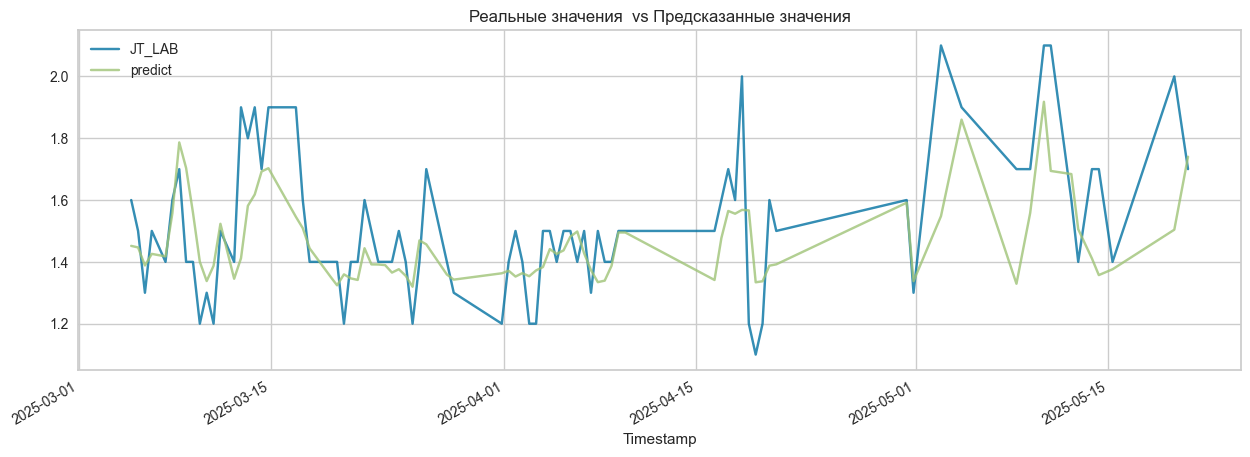

In [250]:
predict_result(X_train, X_test, y_train, y_test, best_rf_model)

### Смотрим важность признаков для модели

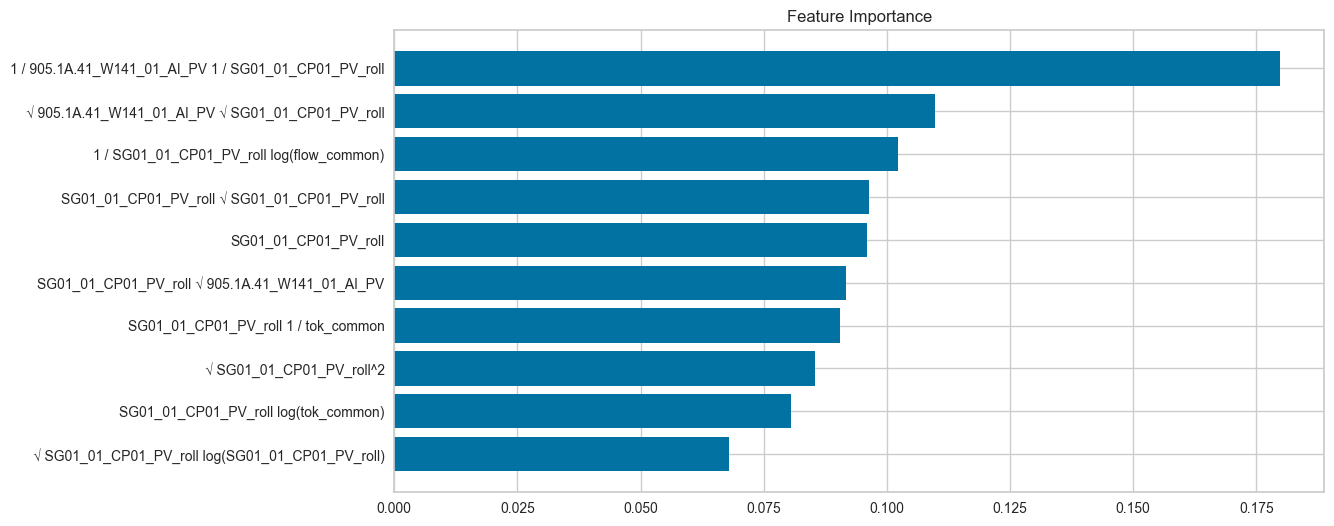

In [251]:
feature_importance = best_rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(selected_columns)[sorted_idx])
plt.title('Feature Importance');

### Просмотрим, как и до этого, метрики на кросс-валидации, но с отобранными гиперпараметрами

Model:  rf
MAE: 0.1495960864247866 ||| MSE: 0.03562688363658319 ||| RMSE: 0.18650074533646885 ||| R2: 0.26872538432729776
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TEST RMSE: 0.1837068823521703 ||| R2: 0.34803287129090177


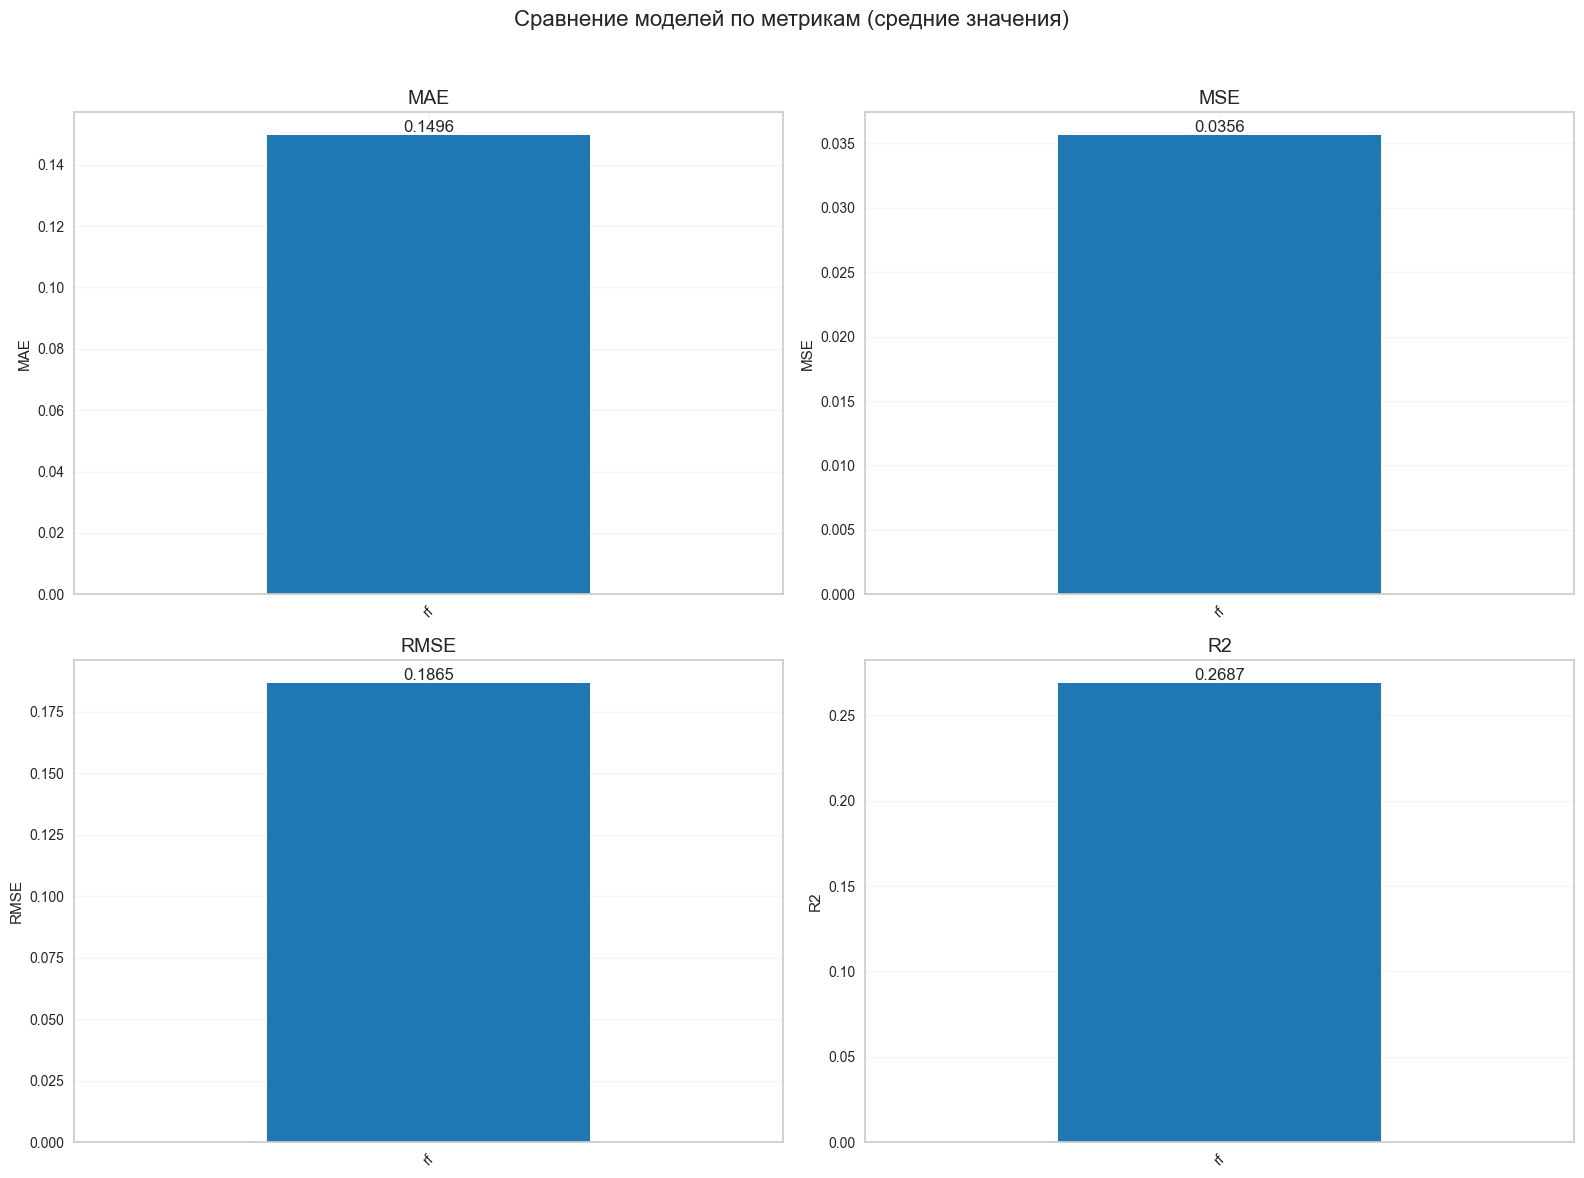

In [252]:
from sklearn.linear_model import BayesianRidge, Ridge, Lasso, LinearRegression,  HuberRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

SEED = 42
num_folds = 5
reses_rf = {}

reses_rf["rf"]  = get_cross_valid_scores(RandomForestRegressor(random_state=SEED, **rf_best_params), "rf", num_folds)
import matplotlib.pyplot as plt
import numpy as np

# Собираем средние значения метрик
metrics_data = {}
for model_name, res in reses_rf.items():
    metrics_data[model_name] = {
        'MAE': -res['test_MAE'].mean(),
        'MSE': -res['test_MSE'].mean(),
        'RMSE': -res['test_RMSE'].mean(),
        'R2': res['test_R2'].mean()
    }

models = list(metrics_data.keys())
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
colors = plt.cm.tab10(np.arange(len(models)))

# Настройка графиков
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Сравнение моделей по метрикам (средние значения)', fontsize=16)

for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    ax = axs[row, col]
    
    # Значения для текущей метрики
    values = [metrics_data[model][metric] for model in models]
    bars = ax.bar(models, values, color=colors, width=0.3)
    
    # Подписи значений
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, 
                f'{yval:.4f}', 
                ha='center', va='bottom', fontsize=12)
    
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.2)
        # Удалим пустое место слева/справа
    ax.margins(x=0.6) 

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

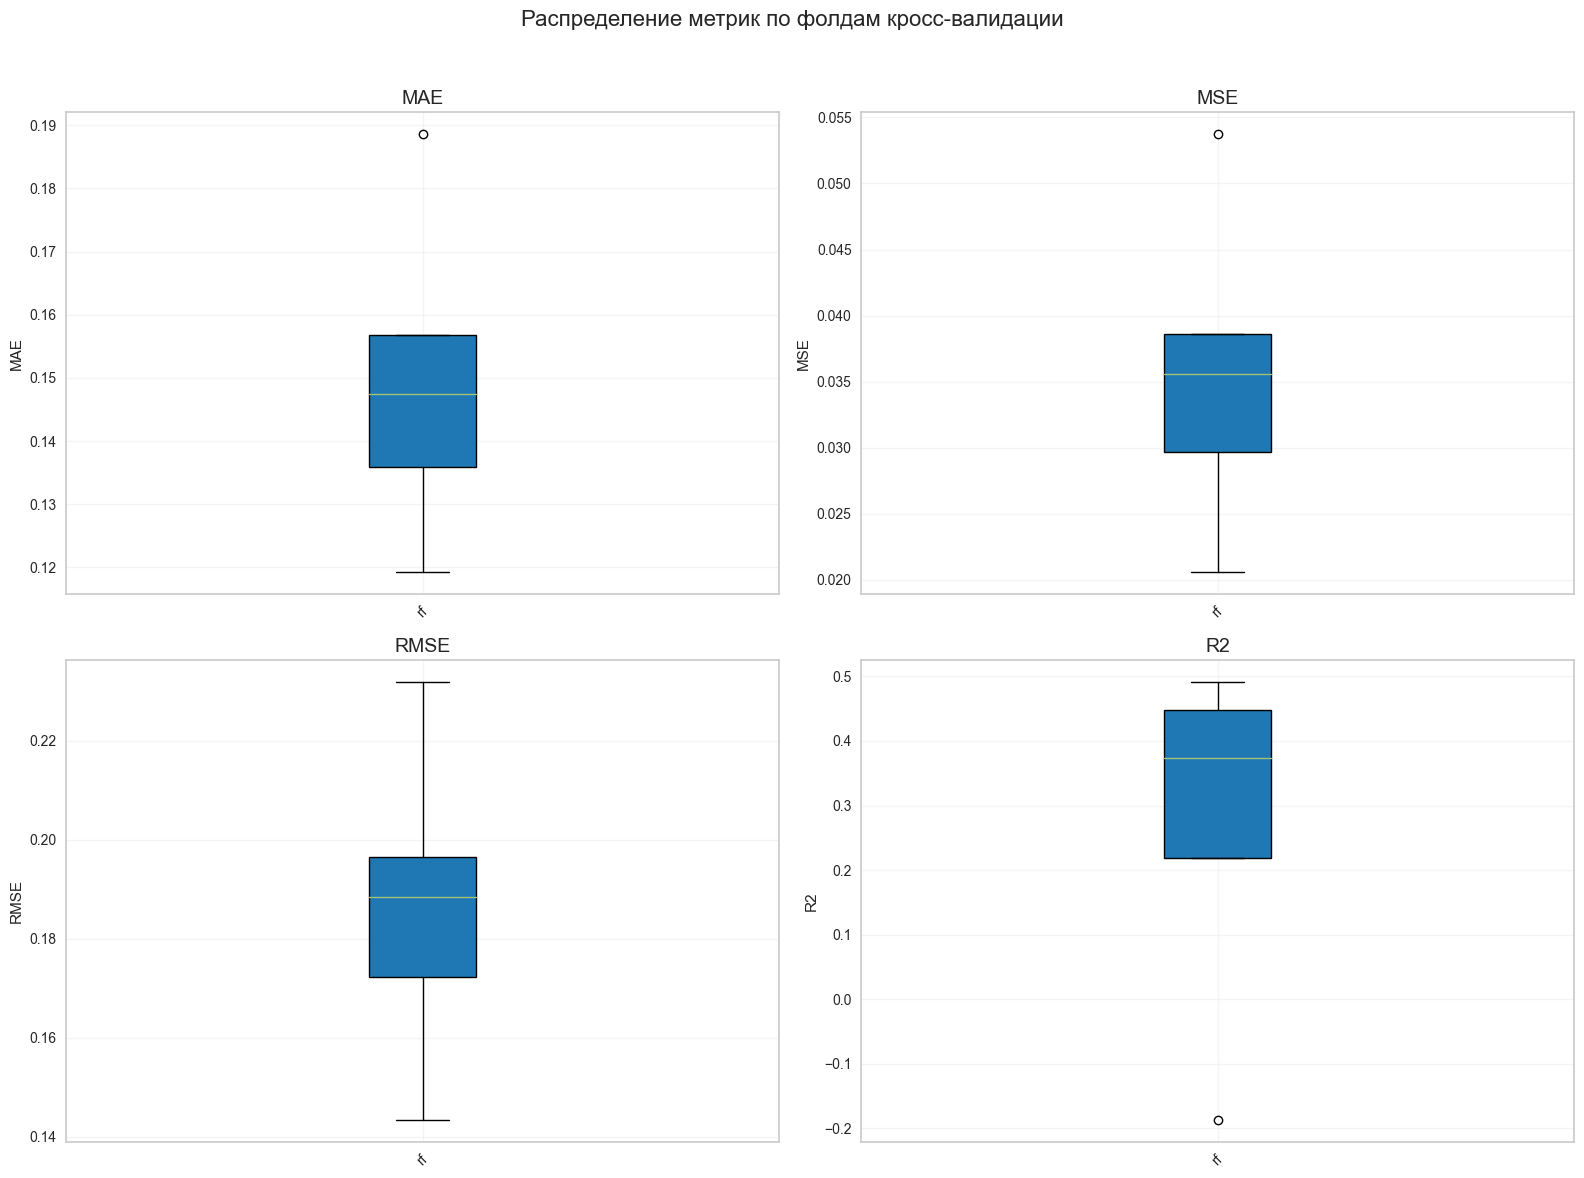

In [184]:
# Собираем данные по фолдам
folds_data = {}
for model_name, res in reses_rf.items():
    folds_data[model_name] = {
        'MAE': -res['test_MAE'],
        'MSE': -res['test_MSE'],
        'RMSE': -res['test_RMSE'],
        'R2': res['test_R2']
    }

# Настройка графиков
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Распределение метрик по фолдам кросс-валидации', fontsize=16)

for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    ax = axs[row, col]
    
    # Подготовка данных для boxplot
    data = [folds_data[model][metric] for model in models]
    box = ax.boxplot(data, patch_artist=True, labels=models)
    
    # Раскрашиваем боксы
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Подбор параметров для LightGBM

In [253]:
train, valid, test =  clean_df[:int(0.7 *clean_df.shape[0])], clean_df[int(0.7 * clean_df.shape[0]):int(0.85 * clean_df.shape[0])], clean_df[int(0.85 *clean_df.shape[0]):]

# Выделяем фичи и таргет
#########################################################
X_train = train[selected_columns]
X_valid = valid[selected_columns]
X_test = test[selected_columns]

y_train = train[target]
y_valid = valid[target]
y_test = test[target]

In [223]:
import optuna
from sklearn.metrics import mean_squared_error
import numpy as np

import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation

def objective_lgb(trial):
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 4000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'verbose': -1,  # Теперь verbose управляется через callbacks
        'random_state': 104,
    }

    # # Дополнительные параметры для 'dart'
    # if params['boosting_type'] == 'dart':
    #     params['drop_rate'] = trial.suggest_float('drop_rate', 0.1, 0.5)
    #     params['skip_drop'] = trial.suggest_float('skip_drop', 0.1, 0.5)

    # Создаем модель без ранней остановки
    model = lgb.LGBMRegressor(**params)

    # Добавляем раннюю остановку через callbacks
    callbacks = [
        early_stopping(stopping_rounds=100, verbose=False),  # Ранняя остановка
        log_evaluation(period=0)  # Отключаем логирование
    ]

    # Обучение с eval_set и callbacks
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],  # Валидационный набор
        callbacks=callbacks  # Используем callbacks
    )

    # Предсказание и метрика
    preds = model.predict(X_valid)
    return root_mean_squared_error(y_valid, preds)

# Запуск Optuna
study_lgb = optuna.create_study(direction='minimize',
                                sampler=optuna.samplers.TPESampler(seed=104))
study_lgb.optimize(objective_lgb, n_trials=200)

[I 2025-06-24 21:13:22,660] A new study created in memory with name: no-name-916be3da-9f1a-429e-b153-6940e7c068f6
[I 2025-06-24 21:13:23,555] Trial 0 finished with value: 1.5472907825225863 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': 5, 'learning_rate': 0.009919353004602042, 'n_estimators': 3112, 'subsample': 0.7621758091314295, 'colsample_bytree': 0.9983618152013041, 'reg_alpha': 4.858254853534322, 'reg_lambda': 6.51420117885684, 'min_child_samples': 20}. Best is trial 0 with value: 1.5472907825225863.
[I 2025-06-24 21:13:23,997] Trial 1 finished with value: 1.5547845277635084 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': 6, 'learning_rate': 0.01197157796860567, 'n_estimators': 1730, 'subsample': 0.972291553740644, 'colsample_bytree': 0.6668410995050386, 'reg_alpha': 7.5959507013364425, 'reg_lambda': 1.2320216800466477, 'min_child_samples': 22}. Best is trial 0 with value: 1.5472907825225863.
[I 2025-06-24 21:13:24,103] Trial 2 f

In [224]:
SEED = 104
lgb_best_params = study_lgb.best_params
best_lgb_model = lgb.LGBMRegressor(**lgb_best_params)

In [225]:
lgb_best_params

{'boosting_type': 'gbdt',
 'num_leaves': 36,
 'max_depth': 9,
 'learning_rate': 0.17058828603043985,
 'n_estimators': 2123,
 'subsample': 0.6127285819837733,
 'colsample_bytree': 0.6122463005924776,
 'reg_alpha': 0.7652084727913538,
 'reg_lambda': 1.0419862125967314,
 'min_child_samples': 23}

In [226]:
optuna.visualization.plot_param_importances(study_lgb)

In [227]:
optuna.visualization.plot_parallel_coordinate(study_lgb)

In [254]:
split_point = int(len(clean_df) * 0.8)
train = clean_df.iloc[:split_point]
test = clean_df.iloc[split_point:]

#########################################################
X_train = train[selected_columns]
X_test = test[selected_columns]
y_train = train[target]
y_test = test[target]

Model:  lgb
MAE: 0.15396475626673795 ||| MSE: 0.03822214004970862 ||| RMSE: 0.19358471890811205 ||| R2: 0.21284298344947955
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
TEST RMSE: 0.2090785345861756 ||| R2: 0.1555114979232297


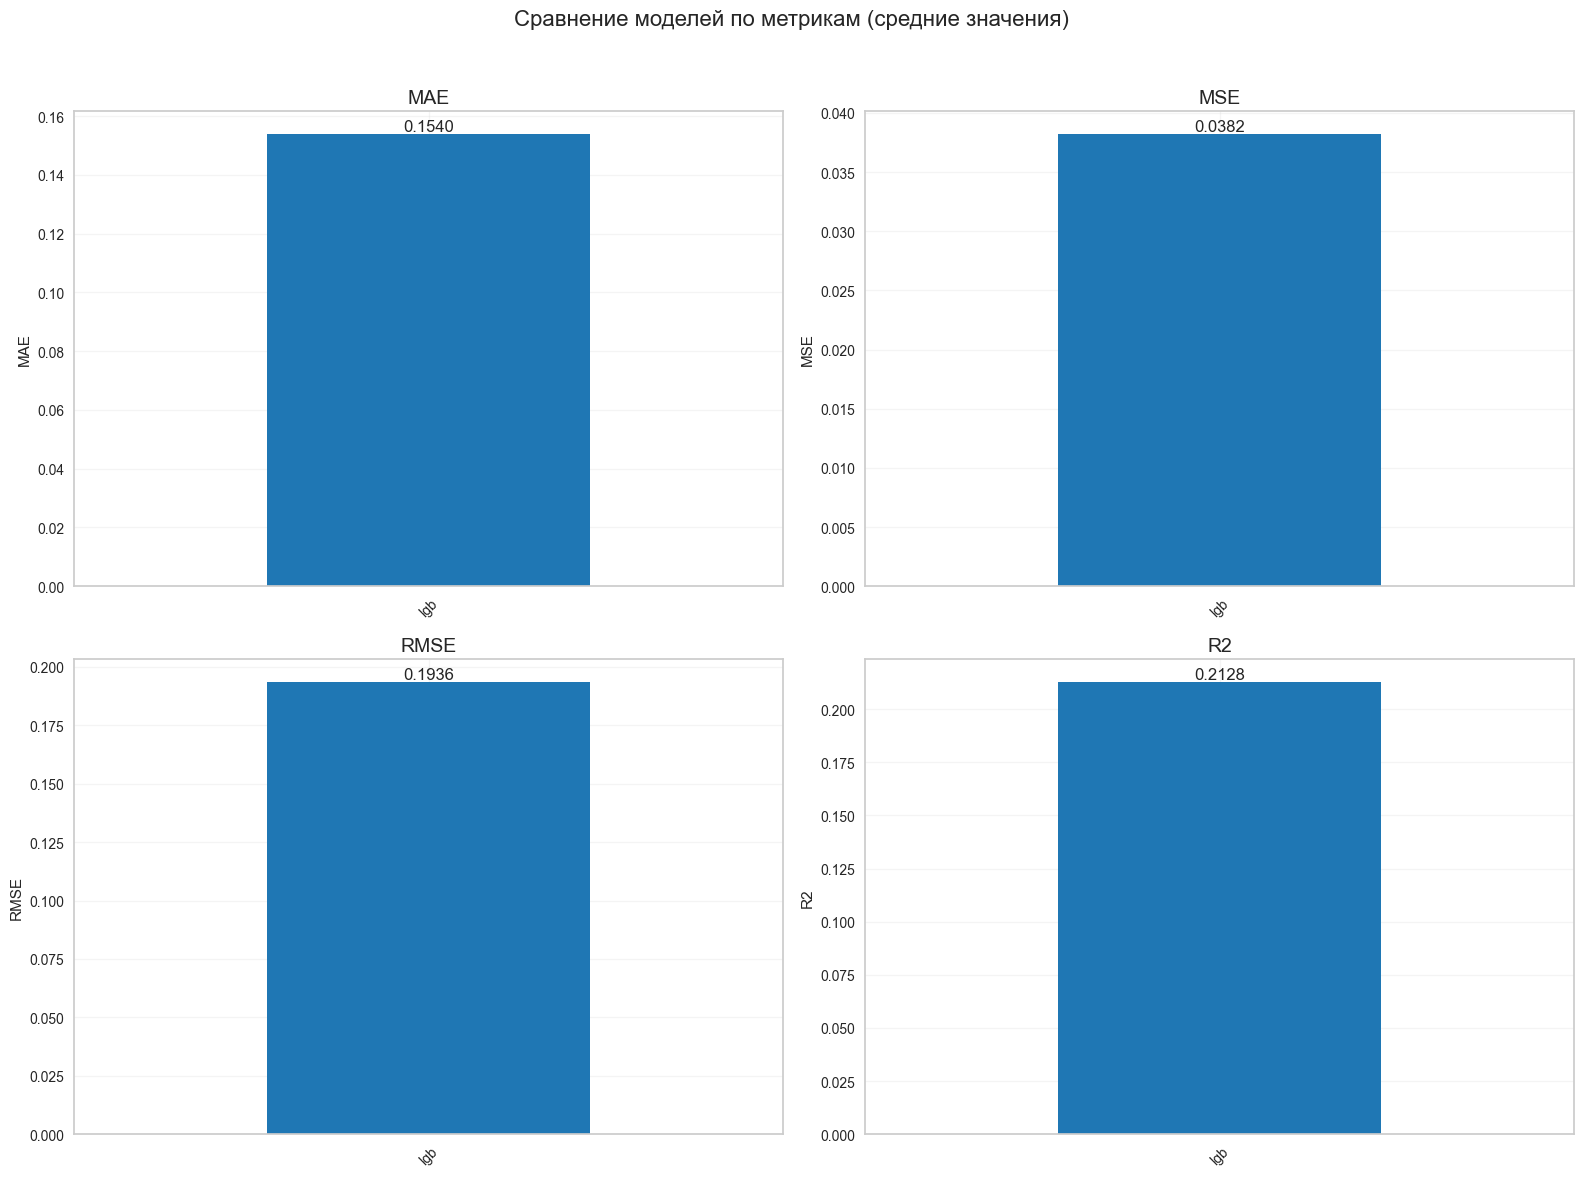

In [255]:
from sklearn.linear_model import BayesianRidge, Ridge, Lasso, LinearRegression,  HuberRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

SEED = 42
num_folds = 5
reses_lgb = {}

reses_lgb["lgb"]  = get_cross_valid_scores(best_lgb_model, "lgb", num_folds)
import matplotlib.pyplot as plt
import numpy as np

# Собираем средние значения метрик
metrics_data = {}
for model_name, res in reses_lgb.items():
    metrics_data[model_name] = {
        'MAE': -res['test_MAE'].mean(),
        'MSE': -res['test_MSE'].mean(),
        'RMSE': -res['test_RMSE'].mean(),
        'R2': res['test_R2'].mean()
    }

models = list(metrics_data.keys())
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
colors = plt.cm.tab10(np.arange(len(models)))

# Настройка графиков
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Сравнение моделей по метрикам (средние значения)', fontsize=16)

for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    ax = axs[row, col]
    
    # Значения для текущей метрики
    values = [metrics_data[model][metric] for model in models]
    bars = ax.bar(models, values, color=colors, width=0.3)
    
    # Подписи значений
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, 
                f'{yval:.4f}', 
                ha='center', va='bottom', fontsize=12)
    
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.2)
        # Удалим пустое место слева/справа
    ax.margins(x=0.6) 

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

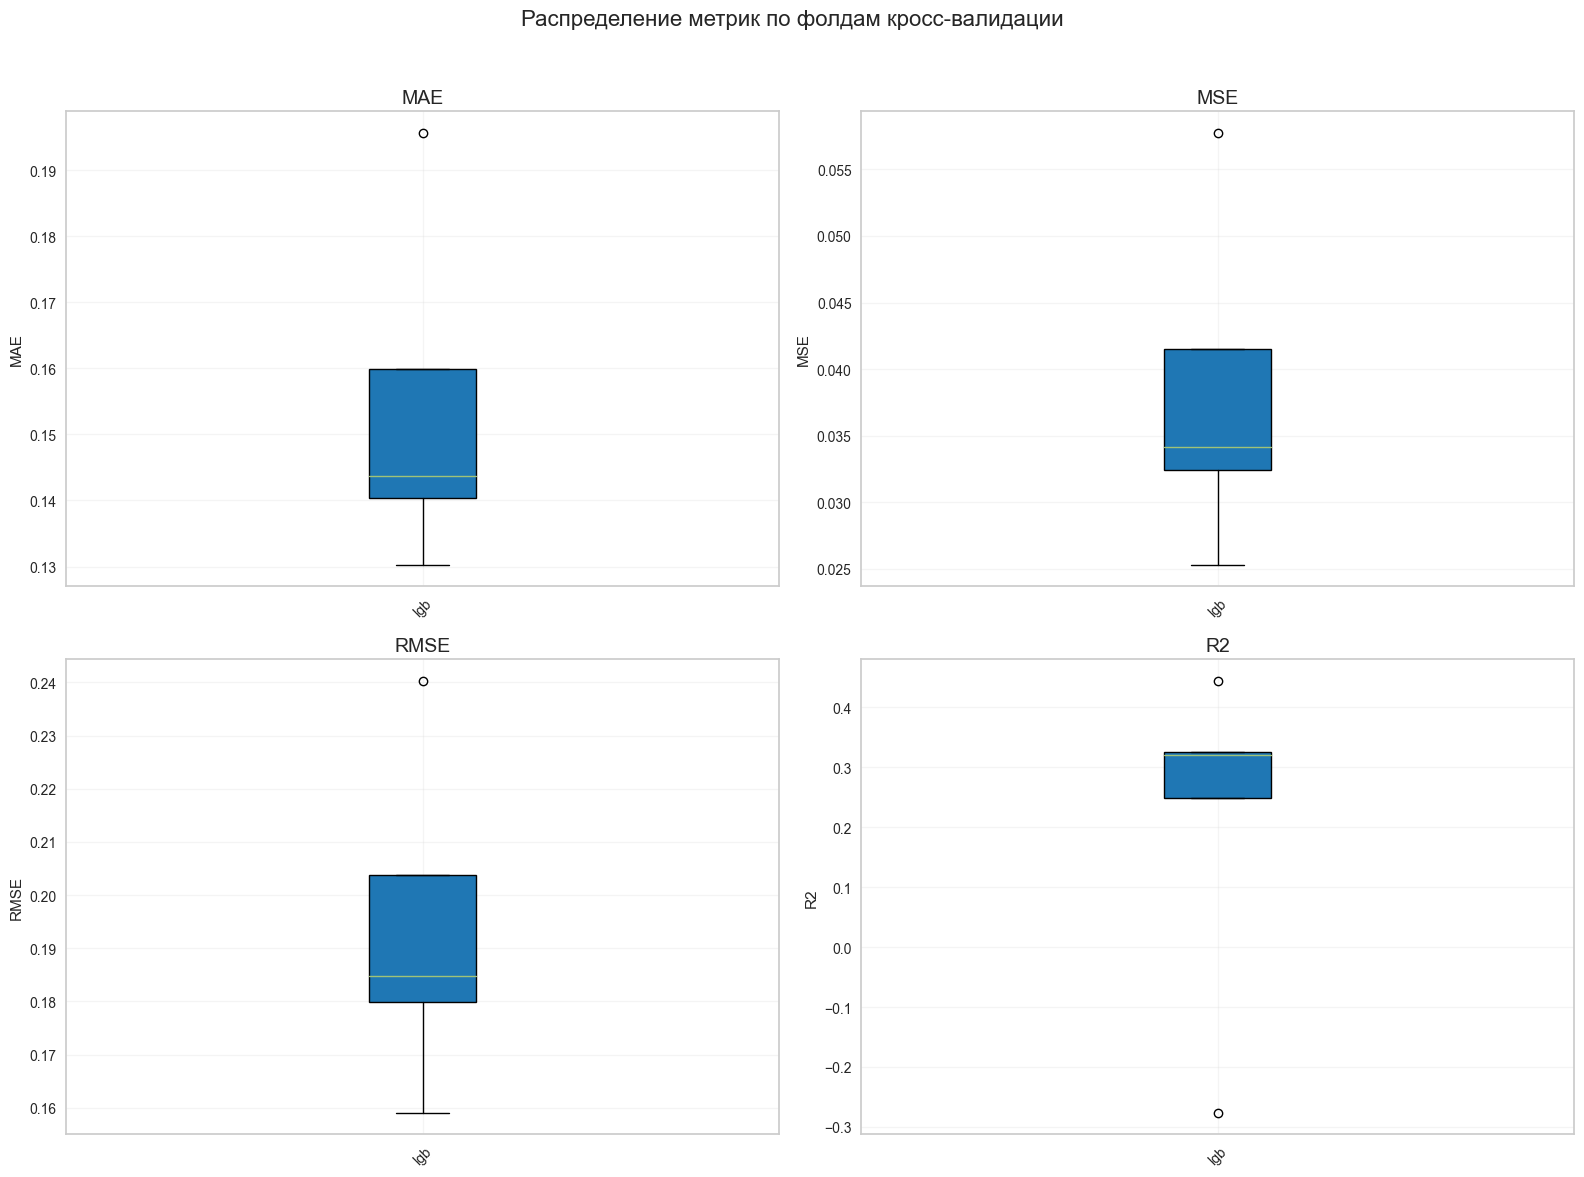

In [230]:
# Собираем данные по фолдам
folds_data = {}
for model_name, res in reses_lgb.items():
    folds_data[model_name] = {
        'MAE': -res['test_MAE'],
        'MSE': -res['test_MSE'],
        'RMSE': -res['test_RMSE'],
        'R2': res['test_R2']
    }

# Настройка графиков
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Распределение метрик по фолдам кросс-валидации', fontsize=16)

for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    ax = axs[row, col]
    
    # Подготовка данных для boxplot
    data = [folds_data[model][metric] for model in models]
    box = ax.boxplot(data, patch_artist=True, labels=models)
    
    # Раскрашиваем боксы
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Тренировочная выборка -  332
Тестовая выборка -  83
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Train MAE: 0.10378118810327404
Test  MAE : 0.15619091838896138
--------------------------------------------------------------------------------
Train MSE: 0.017616651453440487
Test  MSE : 0.043713833624702624
--------------------------------------------------------------------------------
Train R2: 0.6716041347700729
Test  R2 : 0.1555114979232297
--------------------------------------------------------------------------------
Train RMSE: 0.1327277343038767
Test  RMSE: 0.2090785345861756
--------------------------------------------------------------------------------
Train MAPE: 0.0699678708182626
Test  MAPE : 0.09821983150094919


<Figure size 800x550 with 0 Axes>

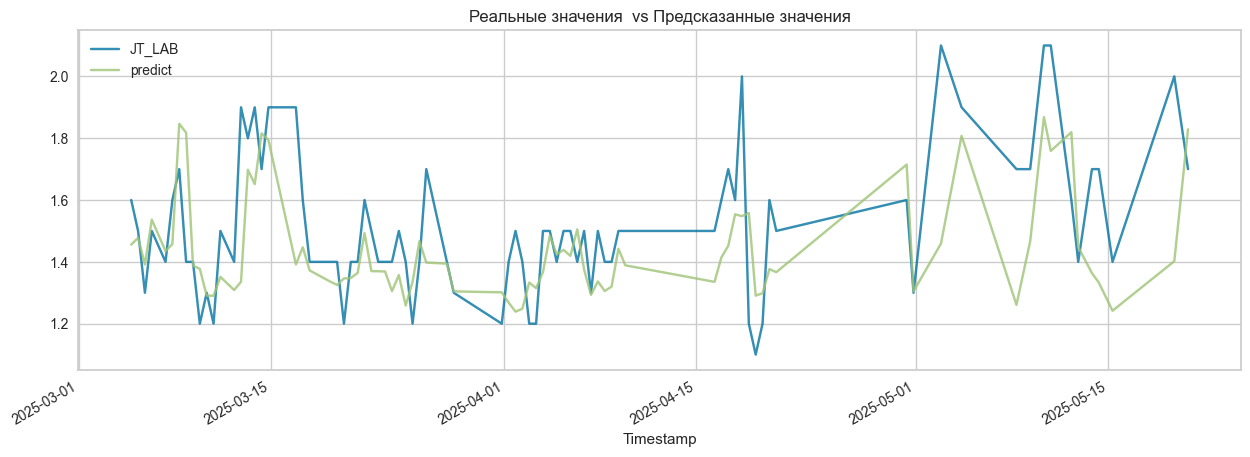

In [256]:
predict_result(X_train, X_test, y_train, y_test, best_lgb_model)

Тренировочная выборка -  332
Тестовая выборка -  83
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Train MAE: 0.10378118810327404
Test  MAE : 0.15619091838896138
--------------------------------------------------------------------------------
Train MSE: 0.017616651453440487
Test  MSE : 0.043713833624702624
--------------------------------------------------------------------------------
Train R2: 0.6716041347700729
Test  R2 : 0.1555114979232297
--------------------------------------------------------------------------------
Train RMSE: 0.1327277343038767
Test  RMSE: 0.2090785345861756
--------------------------------------------------------------------------------
Train MAPE: 0.0699678708182626
Test  MAPE : 0.09821983150094919


<Figure size 800x550 with 0 Axes>

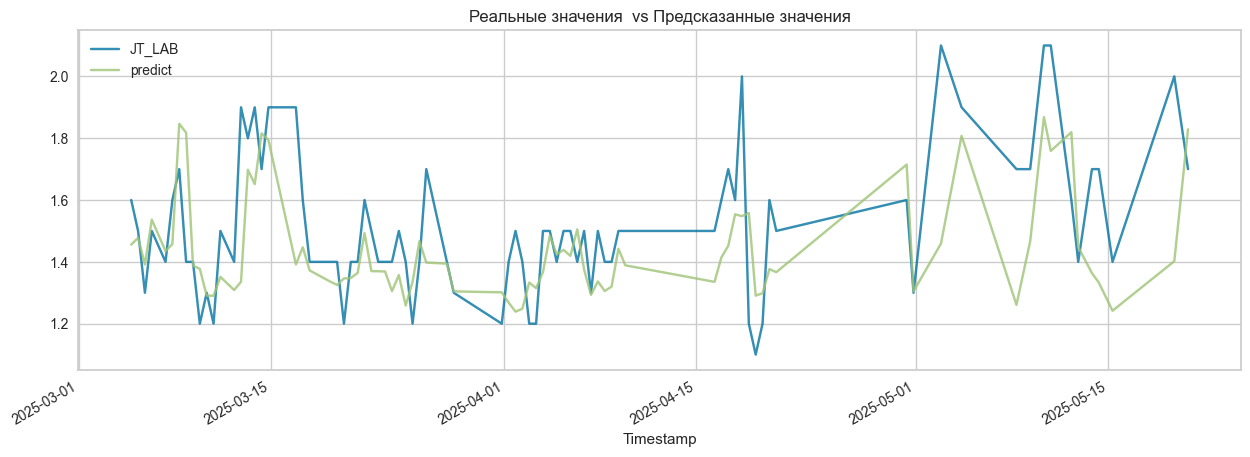

In [ ]:
predict_result(X_train, X_test, y_train, y_test, best_lgb_model)

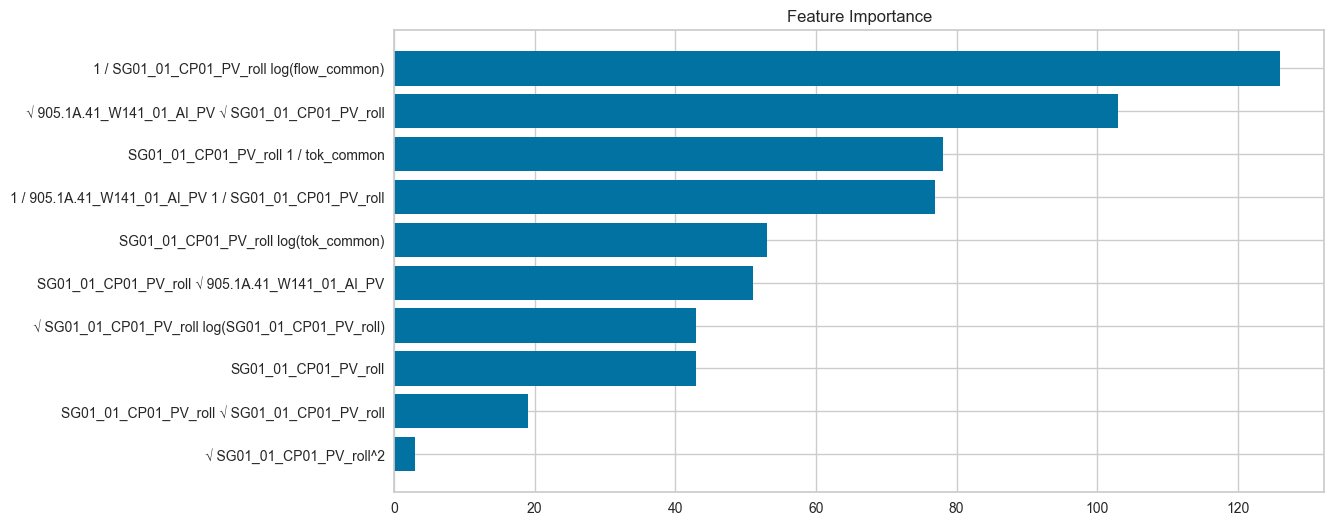

In [257]:
feature_importance = best_lgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(selected_columns)[sorted_idx])
plt.title('Feature Importance');

# Начало пайплана подготовки данных и обучения модели PINN

## Грузим данные из ранее подготовленного датасета

In [ ]:
upload_df = pd.read_csv("data/DATA_FOR_PINN.csv", parse_dates=True, index_col="Timestamp", decimal=",").astype("float32")
upload_df

In [ ]:
upload_df = upload_df.rename(columns={"tok_common": "I", "flow_common": "Q", "reg_common": "n"})

## Также копируем изначальный датасет, далее он будет использоваться как коллокационный

In [ ]:
coll_df = clean_df.copy()
coll_df = coll_df.rename(columns={"tok_common": "I", "flow_common": "Q", "reg_common": "n"})

## Используем технологические константы и константы, полученные из аппроксимации характеристических кривых

In [ ]:
# Кривые H-Q
k1 = 2.478e-05
k2 = 3.954e-06
k3 = -0.0001

# Кривые kpd - Q
kpd_k_0 = 0.1998
kpd_k_1 = 0.0049
kpd_k_2 = -1.162e-05

# Параметры насоса
Mmaks = 22000

# настроечные параметры
er = eta_h = 0.82
Q = 180
nmaks = 886

## Физическая формула

In [ ]:
def physics_rhs_tensor(u, constants):
    I = u[:, 0:1]
    Q_col = u[:, 1:2]
    n_col = u[:, 2:3]


    M = Mmaks * (I / 100.0)
    Q_pred = 0.85 * Q * (M / Mmaks) ** (1.0 / 3.0) + (1.0 - 0.85) * Q_col
    n_pred = (M / Mmaks) ** (1.0 / 3.0)
    H = k1 * (nmaks * n_pred) ** 2 + k2 * nmaks * n_pred * Q_pred + k3 * Q_pred ** 2

    denom1 = (nmaks / (n_pred * nmaks))
    inner = 1 - kpd_k_0 - kpd_k_1 * Q_pred * denom1 - kpd_k_2 * Q_pred ** 2 * (denom1 ** 2)
    base = ((n_pred * nmaks) / nmaks) ** 0.36
    kpd = 1 - (inner / (base + 1e-12))
    kpd_adj = er * kpd
    ro = (3600.0 * M * kpd_adj) / (H * g * Q_pred + 1e-12)
    return ro

## Класс PINN модели

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os

class PINNNet(nn.Module):
    def __init__(self, in_dim=5, hidden=[128, 128, 64], out_dim=1):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers.append(nn.Linear(last, h))
            layers.append(nn.Tanh())
            last = h
        layers.append(nn.Linear(last, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## Функция для стандартизации данных

In [ ]:
def standardize_torch(x, mean=None, std=None):
    if mean is None:
        mean = x.mean(0, keepdim=True)
    if std is None:
        std = x.std(0, unbiased=False, keepdim=True)
        std[std == 0] = 1.0
    return (x - mean) / std, mean, std

## Основная функция обучения PINN модели

In [ ]:
def train_pinn_from_two_dfs(df_coll,
                            df_lab,
                            feature_cols,
                            target_col='DENS_LAB',
                            constants=None,
                            epochs=2000,
                            batch_size=128,
                            lambda_data=1.0,
                            lambda_phys=1.0,
                            lr=1e-3,
                            device='cpu',
                            save_prefix='./pinn_run'):
    """
    df_coll : pd.DataFrame
        Коллокации (частая сетка). Должен содержать колонки feature_cols.
    df_lab : pd.DataFrame
        Лабораторный датасет (редкая сетка). Должен содержать те же feature_cols и столбец target_col.
    feature_cols : list[str]
        Список признаков, например ['I','Q','n','x1','x2'].
    target_col : str
        Имя столбца с лабораторным таргетом в df_lab.
    constants : dict
        Константы для physics_rhs_tensor.
    Остальные параметры: параметры обучения, сохранения и т.д.
    """
    if constants is None:
        constants = {}

    X_coll = df_coll[feature_cols].values.astype(np.float32)  # shape [Ncoll, n_features]

    X_lab = df_lab[feature_cols].values.astype(np.float32)
    y_lab = df_lab[target_col].values.astype(np.float32).reshape(-1, 1)

    # -- Преобразуем в torch tensors --
    X_coll_t = torch.tensor(X_coll, dtype=torch.float32, device=device)
    X_lab_t = torch.tensor(X_lab, dtype=torch.float32, device=device)
    y_lab_t = torch.tensor(y_lab, dtype=torch.float32, device=device)

    # -- Нормализация (по collocations) --
    X_coll_std, X_mean, X_stddev = standardize_torch(X_coll_t)
    # сохранение mean/std для последующего инференса
    input_mean = X_mean.detach().cpu().numpy()
    input_std = X_stddev.detach().cpu().numpy()

    # применяем ту же нормализацию к lab-inputs
    X_lab_std = (X_lab_t - X_mean) / (X_stddev + 1e-12)

    # -- Dataloaders --
    coll_dataset = TensorDataset(X_coll_std.detach().cpu(), torch.zeros(X_coll_std.shape[0], 1))
    coll_loader = DataLoader(coll_dataset, batch_size=batch_size, shuffle=False)

    lab_dataset = TensorDataset(X_lab_std.detach().cpu(), y_lab_t.detach().cpu())
    lab_loader = DataLoader(lab_dataset, batch_size=min(batch_size, len(X_lab_std)), shuffle=False)

    # -- Model & optimizer --
    model = PINNNet(in_dim=len(feature_cols)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'epoch': [], 'loss': [], 'data_loss': [], 'phys_loss': []}

    # -- Training loop --
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        total_loss_epoch = 0.0
        data_loss_epoch = 0.0
        phys_loss_epoch = 0.0
        lab_iter = iter(lab_loader)

        for Xc_batch_cpu, _ in coll_loader:
            Xc_batch = Xc_batch_cpu.to(device).float()    # normalized collocation inputs
            rho_pred_coll = model(Xc_batch)

            # unstandardize для вычисления physics_rhs на оригинальной шкале
            Xc_orig = Xc_batch * torch.tensor(input_std, device=device) + torch.tensor(input_mean, device=device)
            rhs_coll = physics_rhs_tensor(Xc_orig, constants).to(device).float()

            L_phys = torch.mean((rho_pred_coll - rhs_coll) ** 2)

            # supervised minibatch (lab)
            try:
                Xl_batch_cpu, yl_batch_cpu = next(lab_iter)
            except StopIteration:
                lab_iter = iter(lab_loader)
                Xl_batch_cpu, yl_batch_cpu = next(lab_iter)

            Xl_batch = Xl_batch_cpu.to(device).float()
            yl_batch = yl_batch_cpu.to(device).float()

            rho_pred_lab = model(Xl_batch)
            L_data = torch.mean((rho_pred_lab - yl_batch) ** 2)

            loss = lambda_data * L_data + lambda_phys * L_phys

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss_epoch += loss.item() * Xc_batch.shape[0]
            data_loss_epoch += L_data.item() * Xc_batch.shape[0]
            phys_loss_epoch += L_phys.item() * Xc_batch.shape[0]

        # усреднение по числу коллокаций (чтобы метрики были сопоставимы с прошлой версией)
        Ncoll = X_coll_std.shape[0]
        total_loss_epoch /= Ncoll
        data_loss_epoch /= Ncoll
        phys_loss_epoch /= Ncoll

        history['epoch'].append(epoch)
        history['loss'].append(total_loss_epoch)
        history['data_loss'].append(data_loss_epoch)
        history['phys_loss'].append(phys_loss_epoch)

        if epoch <= 5 or epoch % max(1, epochs // 10) == 0:
            print(f"Epoch {epoch}/{epochs} | total={total_loss_epoch:.3e} | data={data_loss_epoch:.3e} | phys={phys_loss_epoch:.3e}")

    # -- Сохранение артефактов --
    os.makedirs(os.path.dirname(save_prefix) or '.', exist_ok=True)
    errors_path = save_prefix + "_errors.npy"
    np.save(errors_path, np.vstack([history['loss'], history['data_loss'], history['phys_loss']]))
    model_path = save_prefix + "_model.pth"
    torch.save(model.state_dict(), model_path)

    # -- Графики (каждая метрика на отдельном графике) --
    plt.figure(); plt.semilogy(history['epoch'], history['loss']); plt.title("Total loss (log)"); plt.xlabel("Epoch"); plt.grid(True); plt.savefig(save_prefix + "_total_loss.png"); plt.show()
    plt.figure(); plt.semilogy(history['epoch'], history['data_loss']); plt.title("Data loss (log)"); plt.xlabel("Epoch"); plt.grid(True); plt.savefig(save_prefix + "_data_loss.png"); plt.show()
    plt.figure(); plt.semilogy(history['epoch'], history['phys_loss']); plt.title("Physics loss (log)"); plt.xlabel("Epoch"); plt.grid(True); plt.savefig(save_prefix + "_phys_loss.png"); plt.show()

    return {
        'model': model,
        'input_mean': input_mean,
        'input_std': input_std,
        'history': history,
        'errors_path': errors_path,
        'model_path': model_path
    }

In [ ]:
results = train_pinn_from_two_dfs(df_coll=coll_df,
                                  df_lab=upload_df,
                                  feature_cols=["I", "Q", "n", 'dav_common', 'SG01_02_CP01_PV_roll', 'SG01_02_FEED_PV_roll'],
                                  target_col='DENS_LAB',
                                  constants={},
                                  epochs=100,
                                  batch_size=256,
                                  lambda_data=1.0,
                                  lambda_phys=1.0,
                                  lr=1e-3,
                                  device='cuda:0')

1%|          | 1/100 [00:11<19:20, 11.72s/it]Epoch 1/100 | total=4.088e+06 | data=1.928e+06 | phys=2.161e+06

  2%|▏         | 2/100 [00:23<19:14, 11.78s/it]Epoch 2/100 | total=3.583e+06 | data=1.683e+06 | phys=1.901e+06

  3%|▎         | 3/100 [00:35<18:59, 11.75s/it]Epoch 3/100 | total=3.122e+06 | data=1.459e+06 | phys=1.663e+06

  4%|▍         | 4/100 [00:48<19:35, 12.24s/it]Epoch 4/100 | total=2.696e+06 | data=1.254e+06 | phys=1.443e+06
  
  5%|▌         | 5/100 [01:00<19:06, 12.07s/it]Epoch 5/100 | total=2.304e+06 | data=1.065e+06 | phys=1.239e+06
  
 10%|█         | 10/100 [02:02<18:24, 12.27s/it]Epoch 10/100 | total=8.266e+05 | data=3.615e+05 | phys=4.651e+05
 
 20%|██        | 20/100 [03:58<15:19, 11.50s/it]Epoch 20/100 | total=5.343e+03 | data=3.240e+03 | phys=2.103e+03
 
 30%|███       | 30/100 [05:52<13:14, 11.36s/it]Epoch 30/100 | total=5.338e+03 | data=3.346e+03 | phys=1.991e+03
 
 40%|████      | 40/100 [07:47<11:27, 11.46s/it]Epoch 40/100 | total=5.338e+03 | data=3.346e+03 | phys=1.991e+03
 
 50%|█████     | 50/100 [09:48<10:48, 12.97s/it]Epoch 50/100 | total=4.636e+03 | data=3.042e+03 | phys=1.594e+03
 
 60%|██████    | 60/100 [11:47<07:46, 11.65s/it]Epoch 60/100 | total=3.697e+03 | data=2.276e+03 | phys=1.422e+03
 
 70%|███████   | 70/100 [13:41<05:41, 11.38s/it]Epoch 70/100 | total=2.547e+03 | data=1.573e+03 | phys=9.742e+02
 
 80%|████████  | 80/100 [15:34<03:48, 11.43s/it]Epoch 80/100 | total=1.798e+03 | data=1.055e+03 | phys=7.425e+02
 
 90%|█████████ | 90/100 [17:29<01:55, 11.52s/it]Epoch 90/100 | total=1.474e+03 | data=8.650e+02 | phys=6.095e+02
 
100%|██████████| 100/100 [19:23<00:00, 11.64s/it]Epoch 100/100 | total=1.205e+03 | data=6.844e+02 | phys=5.210e+02


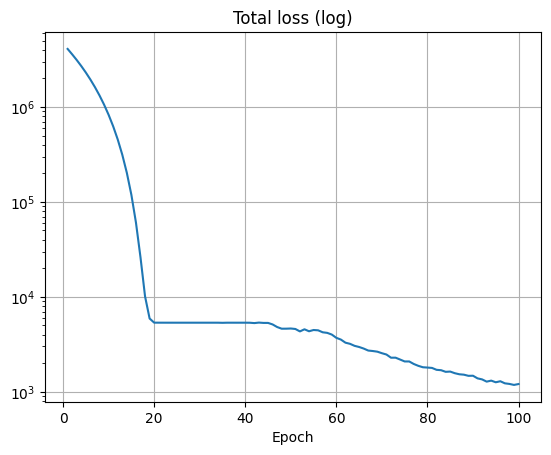

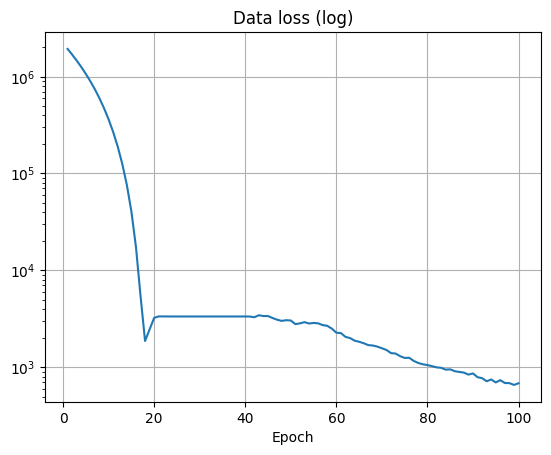

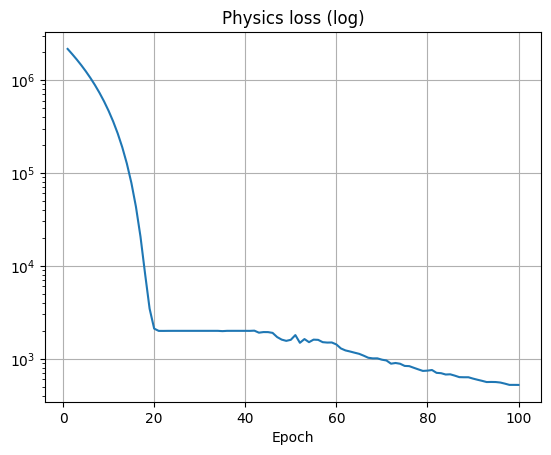

## Проверка модели через инференс

In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import Optional

def predict_and_add_column(df_lab: pd.DataFrame,
                           feature_cols: list,
                           model: Optional[torch.nn.Module] = None,
                           input_mean: Optional[np.ndarray] = None,
                           input_std: Optional[np.ndarray] = None,
                           model_path: Optional[str] = None,
                           device: str = 'cpu',
                           batch_size: int = 1024,
                           output_col: str = 'rho_pred_model') -> pd.DataFrame:

    # создаём модель если надо (предполагается, что PINNNet определён в окружении)
    if model is None:
        # создайте модель с теми же параметрами архитектуры, что и при обучении
        model = PINNNet(in_dim=len(feature_cols))
        map_location = torch.device(device)
        state = torch.load(model_path, map_location=map_location)
        model.load_state_dict(state)

    model.to(device)
    model.eval()

    # приводит mean/std к вектору формы (n_features,)
    input_mean = np.asarray(input_mean).reshape(-1)
    input_std = np.asarray(input_std).reshape(-1)

    # Забираем признаки из df_lab (в порядке feature_cols)
    X = df_lab[feature_cols].values.astype(np.float32)  # shape (N, n_features)

    # Если в df_lab есть NaN в признаках — либо падать, либо пропускать строки.
    if np.isnan(X).any():
        # тут мы заменим NaN на 0 и затем пометим предсказание NaN для этих строк:
        nan_mask = np.any(np.isnan(X), axis=1)
    else:
        nan_mask = np.zeros(X.shape[0], dtype=bool)

    # заменяем NaN временно на 0 для вычислений (предсказания затем занулены)
    X_clean = np.nan_to_num(X, nan=0.0)

    # стандартизация: (X - mean)/std
    X_std = (X_clean - input_mean) / (input_std + 1e-12)

    # предсказания батчами
    preds = np.zeros((X_std.shape[0],), dtype=np.float32)
    with torch.no_grad():
        for start in range(0, X_std.shape[0], batch_size):
            end = start + batch_size
            xb = torch.tensor(X_std[start:end], dtype=torch.float32, device=device)
            yb = model(xb)  # shape [B,1]
            yb_np = yb.squeeze(-1).cpu().numpy()
            preds[start:end] = yb_np

    # Для строк с NaN в входе можно поставить NaN в предсказании:
    preds[nan_mask] = np.nan

    # создаём новый DF (копия) и добавляем столбец
    df_out = df_lab.copy()
    df_out[output_col] = preds

    return df_out

In [ ]:
df_lab_with_preds = predict_and_add_column(df_lab=upload_df,
                                           feature_cols=["I", "Q", "n", 'dav_common', 'SG01_02_CP01_PV_roll', 'SG01_02_FEED_PV_roll'],
                                           model=results["model"],            # или model_path='...pth'
                                           input_mean=results["input_mean"],          # из train_pinn...
                                           input_std=results["input_std"],
                                           device='cpu',
                                           batch_size=2048,
                                           output_col='rho_pred_model')

In [ ]:
df_lab_with_preds_test = df_lab_with_preds[["DENS_LAB", "ro", "rho_pred_model"]].copy()

In [ ]:
r2_score(df_lab_with_preds_test["DENS_LAB"], df_lab_with_preds_test["ro"])

-4.050602923680038

In [ ]:
r2_score(df_lab_with_preds_test["DENS_LAB"], df_lab_with_preds_test["rho_pred_model"])

0.5378975538536284